In [1]:
#!/usr/bin/env python
# coding: utf-8

import os
import re
import math
import random
import unicodedata

import pandas as pd
import numpy as np
import networkx as nx
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="whitegrid")

# Ensure 'plots' directory exists
if not os.path.exists('plots'):
    os.makedirs('plots')

# Load the processed dataset
df = pd.read_csv("./Data/wiki_RfA_2010_2013.csv")
print("Data Types:")
print(df.dtypes)

df


Data Types:
SRC            object
TGT            object
VOT             int64
RES             int64
YEA             int64
DAT            object
TXT            object
cleaned_TXT    object
dtype: object


,SRC,TGT,VOT,RES,YEA,DAT,TXT,cleaned_TXT
0,Steel1943,BDD,1,1,2013,2013-04-19 23:13:00,'''''' as co-nom.,co
1,Cuchullain,BDD,1,1,2013,2013-04-20 01:04:00,'''''' as nominator.--,nominator
2,INeverCry,BDD,1,1,2013,2013-04-19 23:43:00,'''''' per noms.,noms
3,Cncmaster,BDD,1,1,2013,2013-04-20 00:11:00,'''''' per noms. BDD is a strong contributor w...,noms bdd strong contributor thousand edits yea...
4,Miniapolis,BDD,1,1,2013,2013-04-20 00:56:00,"'''''', with great pleasure. I work with BDD a...",great pleasure work bdd coordinator seen good ...
...,...,...,...,...,...,...,...,...
32305,Atama,ZooPro,-1,-1,2010,2010-02-22 18:17:00,"'''''' - Per Polargeo, and per [http://en.wiki...",polargeo deal killer someone want work deletio...
32306,Bradjamesbrown,ZooPro,-1,-1,2010,2010-02-22 18:18:00,'''''' per SilkTork's diff above. Asserting [[...,silktork asserting article portal good behavio...
32307,Ottawa4ever,ZooPro,0,-1,2010,2010-02-22 18:11:00,"'''''' Not to pile on, neutral. I cannot suppo...",pile neutral support smithers pointed feeding ...
32308,Tryptofish,ZooPro,0,-1,2010,2010-02-22 17:58:00,'''''' I've interacted with this editor at var...,interacted editor various animal related page ...


## Construct Multigraph

Constructs the directed multi-graph with signed edges.


Prints number of nodes/edges and distribution of positive/negative edges.

In [5]:
import networkx as nx

def create_signed_graph(df):
    """
    Create a DiGraph from the DataFrame and track admin status progression.
    A node can transition from nonAdmin to admin based on the 'RES' column.
    """
    # Sort dataframe by date ascending to process chronologically
    df_sorted = df.sort_values(by='DAT', ascending=True).reset_index(drop=True)
    
    G = nx.DiGraph()
    user_admin_status = {}  # To store the final admin status of each user

    for _, row in df_sorted.iterrows():
        src, tgt, vot = row['SRC'], row['TGT'], row['VOT']
        txt, res, dat = row['TXT'], row['RES'], row['DAT']
        
        # Only allow vot values of -1 or 1
        if vot not in [-1, 1]:
            continue
        
        # Add source node if not present
        if src not in G:
            G.add_node(src)
            user_admin_status[src] = 'nonAdmin'  # Initialize as nonAdmin
        
        # Add target node if not present
        if tgt not in G:
            G.add_node(tgt)
            user_admin_status[tgt] = 'nonAdmin'  # Initialize as nonAdmin
        
        # Update admin status for the target node based on 'RES'
        if res == 1:
            user_admin_status[tgt] = 'admin'
        # If res != 1, retain existing status ('nonAdmin' by default)
        
        # Assign the admin status as a node attribute
        G.nodes[tgt]['admin'] = user_admin_status[tgt]
        
        # Optionally, you can set admin status for src if needed
        # For now, src remains as initially assigned ('nonAdmin' unless updated elsewhere
        
        # Add edge with attributes
        edge_attrs = {'label': vot, 'txt': txt, 'DAT': dat, 'res': res}
        G.add_edge(src, tgt, **edge_attrs)
    
    return G

# Create the signed graph and track user admin status
G = create_signed_graph(df)

# Get the top 10 in-degree users
in_degree_centrality = nx.in_degree_centrality(G)
top_10_in_degree_users = [user for user, _ in sorted(in_degree_centrality.items(), key=lambda item: item[1], reverse=True)[:10]]

# Display the admin status for the top 10 in-degree users
print("Admin Status of Top 10 In-Degree Users:")
for user in top_10_in_degree_users:
    print(f"User {user} is {user_admin_status.get(user, 'Unknown')}.")

# Calculate the proportion of support votes (VOT == 1) for each of the top 10 in-degree users
print("\nProportion of Support Votes for Top 10 In-Degree Users:")
for user in top_10_in_degree_users:
    # Filter the comments for the current user
    user_comments = df[df['SRC'] == user]
    
    # Calculate the proportion of support votes
    total_votes = len(user_comments)
    support_votes = len(user_comments[user_comments['VOT'] == 1])
    support_vote_proportion = support_votes / total_votes if total_votes > 0 else 0
    
    print(f"User {user} has a support vote proportion of {support_vote_proportion:.2f}.")

Admin Status of Top 10 In-Degree Users:
User HJ Mitchell is admin.
User Ironholds is admin.
User Everyking is admin.
User SarekOfVulcan is admin.
User The Thing That Should Not Be is admin.
User Connormah is admin.
User SarahStierch is admin.
User Lord Roem is admin.
User Drmies is admin.
User Σ is admin.

Proportion of Support Votes for Top 10 In-Degree Users:
User HJ Mitchell has a support vote proportion of 0.66.
User Ironholds has a support vote proportion of 0.76.
User Everyking has a support vote proportion of 0.57.
User SarekOfVulcan has a support vote proportion of 0.73.
User The Thing That Should Not Be has a support vote proportion of 0.50.
User Connormah has a support vote proportion of 0.77.
User SarahStierch has a support vote proportion of 1.00.
User Lord Roem has a support vote proportion of 0.82.
User Drmies has a support vote proportion of 0.64.
User Σ has a support vote proportion of 0.64.


In [3]:
# Check if a specific user is an admin
user_id = 'HJ Mitchell'

# Verify if the user exists in the graph
if user_id in G.nodes:
    print(f"User {user_id} is an {G.nodes[user_id].get('admin', 'Unknown')}.")
else:
    print(f"User {user_id} does not exist in the graph.")

G.nodes[user_id]

User HJ Mitchell is an Unknown.


{}

In [250]:
density = nx.density(G)
print(f"Network Density: {density:.4f}")

Network Density: 0.0035


In [251]:
# Calculate the average out-degree for admin nodes
admin_out_degrees = [
    G.out_degree(node) for node, data in G.nodes(data=True) if data.get("admin") == "admin"
]

# Calculate the average out-degree
average_admin_out_degree = sum(admin_out_degrees) / len(admin_out_degrees) if admin_out_degrees else 0

average_admin_out_degree


3.144463667820069

In [252]:
# Calculate the average degree for non-admin nodes
non_admin_degrees = [
    G.out_degree(node) for node, data in G.nodes(data=True) if data.get("admin") == "nonAdmin"
]

# Calculate the average degree
average_non_admin_degree = sum(non_admin_degrees) / len(non_admin_degrees) if non_admin_degrees else 0

average_non_admin_degree

14.970191226096738

In [253]:
# Calculate the normal reciprocity for the entire graph
normal_reciprocity = nx.reciprocity(G)

normal_reciprocity


0.04971572127462647

In [254]:
# Filter edges with label=1 (support) and admin status as "admin"
positive_label_edges = [
    (u, v, k) for u, v, k, d in G.edges(keys=True, data=True)
    if d.get("label") == -1
    
]

# Create a subgraph with only positive label edges
positive_label_subgraph = G.edge_subgraph(positive_label_edges).copy()

# Calculate reciprocity for the subgraph
positive_label_reciprocity = nx.reciprocity(positive_label_subgraph)

print("Reciprocity for positive label edges:", positive_label_reciprocity)


Reciprocity for positive label edges: 0.005819592628516004


 Degree, In-Degree, Out-Degree, and Centrality Measures

In [255]:
# Average degree calculations
total_degree = sum(dict(G.degree()).values())
num_nodes = G.number_of_nodes()
avg_degree = total_degree / num_nodes if num_nodes > 0 else 0
avg_in_degree = sum(dict(G.in_degree()).values()) / num_nodes if num_nodes > 0 else 0
avg_out_degree = sum(dict(G.out_degree()).values()) / num_nodes if num_nodes > 0 else 0

print(f"Average Degree: {avg_degree:.2f}")
print(f"Average In-Degree: {avg_in_degree:.2f}")
print(f"Average Out-Degree: {avg_out_degree:.2f}")



Average Degree: 20.62
Average In-Degree: 10.31
Average Out-Degree: 10.31


In [230]:
import networkx as nx

def print_top_influential(G, centrality_dict, measure_name, top_n=10):
    """
    Print the top 'top_n' nodes by a given centrality measure.

    Parameters:
        G (networkx.Graph or DiGraph): The graph under consideration.
        centrality_dict (dict): Dictionary {node: centrality_value}.
        measure_name (str): Name of the centrality measure.
        top_n (int): Number of top nodes to print.
    """
    sorted_nodes = sorted(centrality_dict.items(), key=lambda x: x[1], reverse=True)
    print(f"\nTop {top_n} nodes by {measure_name}:")
    for i, (node, value) in enumerate(sorted_nodes[:top_n], start=1):
        print(f"{i}. User: {node}, {measure_name}: {value:.4f}")

# Assuming G is your directed graph (e.g., a DiGraph)
# If G is MultiDiGraph, first convert it to DiGraph to ensure compatibility with some measures:
if isinstance(G, nx.MultiDiGraph):
    # Collapsing multiple edges between the same pair into a single edge
    # This step depends on whether multiple edges carry distinct info, else just use G as is
    G = nx.DiGraph(G)

# 1. Degree Centralities
degree_centrality = nx.degree_centrality(G)
in_degree_centrality = nx.in_degree_centrality(G)
out_degree_centrality = nx.out_degree_centrality(G)

print_top_influential(G, degree_centrality, "Degree Centrality")
print_top_influential(G, in_degree_centrality, "In-Degree Centrality")
print_top_influential(G, out_degree_centrality, "Out-Degree Centrality")

# 2. Betweenness Centrality
betweenness_centrality = nx.betweenness_centrality(G, normalized=True)
print_top_influential(G, betweenness_centrality, "Betweenness Centrality")

# 3. Closeness Centrality
closeness_centrality = nx.closeness_centrality(G)
print_top_influential(G, closeness_centrality, "Closeness Centrality")

# 4. (Optional) Eigenvector Centrality
# For eigenvector centrality, the graph should be undirected or we must handle direction:
# Convert G to an undirected version (ignoring edge direction)
G_und = G.to_undirected()
eigenvector_centrality = nx.eigenvector_centrality(G_und, max_iter=1000)
print_top_influential(G, eigenvector_centrality, "Eigenvector Centrality")

# After running this code, you will have lists of the top influential users
# according to different centrality measures.



Top 10 nodes by Degree Centrality:
1. User: HJ Mitchell, Degree Centrality: 0.1418
2. User: Boing! said Zebedee, Degree Centrality: 0.1364
3. User: Ktr101, Degree Centrality: 0.1142
4. User: Fetchcomms, Degree Centrality: 0.1122
5. User: Secret, Degree Centrality: 0.1077
6. User: Ironholds, Degree Centrality: 0.1023
7. User: Connormah, Degree Centrality: 0.0992
8. User: SarekOfVulcan, Degree Centrality: 0.0985
9. User: Kudpung, Degree Centrality: 0.0985
10. User: Airplaneman, Degree Centrality: 0.0979

Top 10 nodes by In-Degree Centrality:
1. User: HJ Mitchell, In-Degree Centrality: 0.0958
2. User: Ironholds, In-Degree Centrality: 0.0852
3. User: Everyking, In-Degree Centrality: 0.0781
4. User: SarekOfVulcan, In-Degree Centrality: 0.0774
5. User: The Thing That Should Not Be, In-Degree Centrality: 0.0760
6. User: Connormah, In-Degree Centrality: 0.0753
7. User: SarahStierch, In-Degree Centrality: 0.0736
8. User: Lord Roem, In-Degree Centrality: 0.0716
9. User: Drmies, In-Degree Centra

In [256]:
degree_centrality = nx.degree_centrality(G)

# Sort users based on degree centrality in descending order
sorted_degree_centrality = sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)

# Identify the top users based on degree centrality
top_users = sorted_degree_centrality[:10]  # Change 10 to the number of top users you want to see

# Check if these top users are admins or non-admins
for user, centrality in top_users:
    role = G.nodes[user].get('role', 'Unknown')  # Assuming 'role' is the attribute that stores admin status
    print(f"User: {user}, Degree Centrality: {centrality:.4f}, Role: {role}")


User: HJ Mitchell, Degree Centrality: 0.1562, Role: Unknown
User: Boing! said Zebedee, Degree Centrality: 0.1388, Role: Unknown
User: Connormah, Degree Centrality: 0.1255, Role: Unknown
User: Ktr101, Degree Centrality: 0.1183, Role: Unknown
User: Fetchcomms, Degree Centrality: 0.1176, Role: Unknown
User: Ironholds, Degree Centrality: 0.1122, Role: Unknown
User: Secret, Degree Centrality: 0.1105, Role: Unknown
User: Lord Roem, Degree Centrality: 0.1101, Role: Unknown
User: Airplaneman, Degree Centrality: 0.1071, Role: Unknown
User: Mkativerata, Degree Centrality: 0.1016, Role: Unknown


In [234]:
import networkx as nx

# Assuming 'G' is your directed graph, convert it to undirected
undirected_graph = G.to_undirected()

# Calculate betweenness centrality on the undirected graph
betweenness_centrality = nx.betweenness_centrality(undirected_graph, normalized=True)

# Sort the dictionary by centrality values in descending order and get the top 10
top_users = sorted(betweenness_centrality.items(), key=lambda item: item[1], reverse=True)[:10]

# Print results
for node, centrality in top_users:
    print(f"Node {node}: Betweenness Centrality = {centrality}")


Node HJ Mitchell: Betweenness Centrality = 0.038047808690507244
Node Boing! said Zebedee: Betweenness Centrality = 0.03561419048201402
Node Everyking: Betweenness Centrality = 0.03364261503619926
Node Ironholds: Betweenness Centrality = 0.029695875398591465
Node SarekOfVulcan: Betweenness Centrality = 0.02671249364061735
Node Ktr101: Betweenness Centrality = 0.026404531975767594
Node Secret: Betweenness Centrality = 0.023253062442604333
Node SarahStierch: Betweenness Centrality = 0.023020970342657075
Node Soap: Betweenness Centrality = 0.02198904642340686
Node Drmies: Betweenness Centrality = 0.02161346471748488


## Centrality Measures

## Participant analysis

Explanation of New Analysis Steps:

    Frequent Voters:
    We focus on nodes with a high out-degree, i.e., those who cast many votes. Then we also look at what fraction of these votes are positive. Nodes that have a high out-degree and a large proportion of positive votes can be considered "frequent supportive voters."

    Broadly Supported Candidates:
    Similarly, for candidates, we examine in-degree. A node with a high in-degree receives many votes; if a large fraction of these votes are positive, we can say the candidate is broadly supported.

    Sorting and Displaying Top Nodes:
    We sort by total incoming or outgoing votes first, and then by the proportion of positive votes. This gives us a ranking of the most active voters and the most supported candidates.

    Visualization:
    We also plot the distribution of the proportion of positive votes cast by voters and the proportion of positive votes received by candidates to understand the overall spread of positivity in the network.

With these expansions, we now have a richer picture of user roles: who are the most active participants in the voting process and who enjoys the most supportive environment in the Wikipedia RfA network.


Top 10 Frequent Voters (Out-degree and proportion of positive votes):
Node: Boing! said Zebedee, Total Outgoing Votes: 246, Positive %: 72.76%
Node: Fastily, Total Outgoing Votes: 242, Positive %: 49.17%
Node: Ktr101, Total Outgoing Votes: 231, Positive %: 92.21%
Node: Fetchcomms, Total Outgoing Votes: 221, Positive %: 61.99%
Node: Mkativerata, Total Outgoing Votes: 185, Positive %: 69.73%
Node: Axl, Total Outgoing Votes: 180, Positive %: 67.78%
Node: Minimac, Total Outgoing Votes: 178, Positive %: 66.85%
Node: RP459, Total Outgoing Votes: 174, Positive %: 83.91%
Node: Kudpung, Total Outgoing Votes: 168, Positive %: 61.90%
Node: WereSpielChequers, Total Outgoing Votes: 161, Positive %: 79.50%

Top 10 Broadly Supported Candidates (In-degree and proportion of positive votes received):
Node: HJ Mitchell, Total Incoming Votes: 314, Positive %: 87.90%
Node: Connormah, Total Incoming Votes: 296, Positive %: 74.66%
Node: Ironholds, Total Incoming Votes: 275, Positive %: 84.00%
Node: Lord Roem

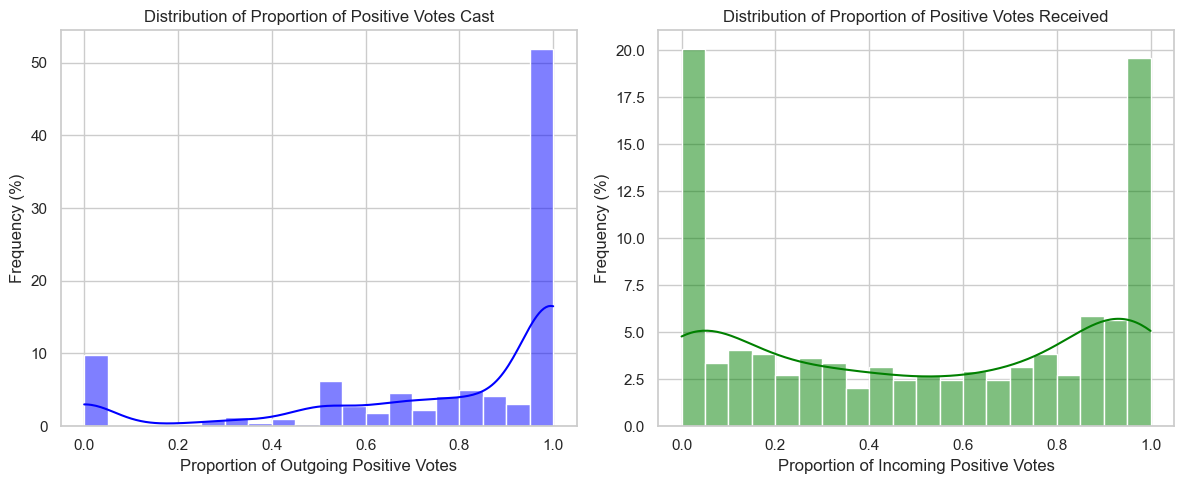

In [13]:
# ### Expanded Centrality Analysis for Frequent Voters and Broadly Supported Candidates

# Already computed dictionaries: degree_info, in_degree_dict, out_degree_dict

# We want to identify:
# - Frequent voters: Nodes with high out-degree and a high proportion of positive edges given.
# - Broadly supported candidates: Nodes with high in-degree and a high proportion of positive edges received.

# Let's recompute some helpful dictionaries focusing on sign of edges:
outgoing_counts = {}
outgoing_positive = {}
incoming_counts = {}
incoming_positive = {}

for u, v, data in G.edges(data=True):
    vot = data.get('label', 0)
    
    # Outgoing edges from u
    outgoing_counts[u] = outgoing_counts.get(u, 0) + 1
    if vot == 1:
        outgoing_positive[u] = outgoing_positive.get(u, 0) + 1

    # Incoming edges to v
    incoming_counts[v] = incoming_counts.get(v, 0) + 1
    if vot == 1:
        incoming_positive[v] = incoming_positive.get(v, 0) + 1

# Compute proportions
voter_info = []
for node in G.nodes():
    total_out = outgoing_counts.get(node, 0)
    pos_out = outgoing_positive.get(node, 0)
    prop_pos_out = (pos_out / total_out) if total_out > 0 else 0
    voter_info.append((node, total_out, prop_pos_out))

candidate_info = []
for node in G.nodes():
    total_in = incoming_counts.get(node, 0)
    pos_in = incoming_positive.get(node, 0)
    prop_pos_in = (pos_in / total_in) if total_in > 0 else 0
    candidate_info.append((node, total_in, prop_pos_in))

# Sort voters by total_out first, then by proportion of positive votes
voters_sorted_by_activity = sorted(voter_info, key=lambda x: (x[1], x[2]), reverse=True)
# Sort candidates by total_in first, then by proportion of positive votes
candidates_sorted_by_support = sorted(candidate_info, key=lambda x: (x[1], x[2]), reverse=True)

print("Top 10 Frequent Voters (Out-degree and proportion of positive votes):")
for node, total_out, prop_pos_out in voters_sorted_by_activity[:10]:
    print(f"Node: {node}, Total Outgoing Votes: {total_out}, Positive %: {prop_pos_out*100:.2f}%")

print("\nTop 10 Broadly Supported Candidates (In-degree and proportion of positive votes received):")
for node, total_in, prop_pos_in in candidates_sorted_by_support[:10]:
    print(f"Node: {node}, Total Incoming Votes: {total_in}, Positive %: {prop_pos_in*100:.2f}%")

# Let's also visualize distributions of these proportions for a sense of overall patterns

outgoing_proportions = [x[2] for x in voter_info if x[1] > 0]
incoming_proportions = [x[2] for x in candidate_info if x[1] > 0]

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.histplot(outgoing_proportions, kde=True, bins=20, color='blue', stat='percent')
plt.title("Distribution of Proportion of Positive Votes Cast")
plt.xlabel("Proportion of Outgoing Positive Votes")
plt.ylabel("Frequency (%)")

plt.subplot(1, 2, 2)
sns.histplot(incoming_proportions, kde=True, bins=20, color='green', stat='percent')
plt.title("Distribution of Proportion of Positive Votes Received")
plt.xlabel("Proportion of Incoming Positive Votes")
plt.ylabel("Frequency (%)")

plt.tight_layout()
plt.savefig('plots/voters_candidates_positive_vote_proportions.png')
plt.show()


##  Triad Analysis

In [8]:
def convert_to_undirected(G):
    U = nx.Graph()
    for u, v, data in G.edges(data=True):
        if U.has_edge(u, v):
            if data.get("label") == -1:
                U[u][v]["label"] = -1
        else:
            U.add_edge(u, v, label=data.get("label"))
    return U

G_undirected = convert_to_undirected(G)

# Triad analysis would typically involve counting triad types
# (Code for triad counting was previously shown; you can integrate it here if needed)

# For brevity, assume triad counts/fractions have been computed.
# If desired, include triad analysis functions and print results.


## Connected Components and Small-World Properties

In [9]:
# Strongly connected components
scc = list(nx.strongly_connected_components(G))
largest_scc = max(scc, key=len)
G_scc = G.subgraph(largest_scc)
avg_path_len = nx.average_shortest_path_length(G_scc)
print(f"Average Shortest Path Length (Largest SCC): {avg_path_len:.3f}")

num_scc = len(scc)
num_wcc = len(list(nx.weakly_connected_components(G)))
print(f"Number of Strongly Connected Components: {num_scc}")
print(f"Number of Weakly Connected Components: {num_wcc}")

# Diameter of largest SCC if strongly connected
if nx.is_strongly_connected(G_scc):
    diameter = nx.diameter(G_scc.to_undirected())
    print(f"Diameter of Largest SCC: {diameter}")


Average Shortest Path Length (Largest SCC): 2.423
Number of Strongly Connected Components: 2641
Number of Weakly Connected Components: 1
Diameter of Largest SCC: 4


import numpy as np
import networkx as nx
from collections import Counter
from sklearn.preprocessing import normalize
import pandas as pd
import matplotlib.pyplot as plt

############################################################
# Utility Functions
############################################################

def getConnections(Edges, N):
    """
    Construct adjacency lists for each node (conns) and a list of non-neighbors (nconns).
    N: Number of nodes
    Edges: List of tuples (u, v)
    """
    all_nodes = set(range(N))
    conns = {i: [] for i in range(N)}
    for (u, v) in Edges:
        conns[u].append(v)
        conns[v].append(u)
    nconns = {}
    for i in range(N):
        nconns[i] = list(all_nodes - set(conns[i]) - {i})
    return conns, nconns

def evalFactor(u, F, conns, nconns):
    """
    Evaluate the contribution of node u to the log-likelihood.
    """
    Fu = F[u]
    res = 0
    # For edges
    for v in conns[u]:
        val = np.dot(Fu, F[v])
        val = np.clip(val, -50, 50)  # Clip for numeric stability
        temp = np.exp(-val)
        # Avoid log(0)
        if temp >= 1:
            res += np.log(1 - min(temp, 0.9999999999))
        else:
            res += np.log(1 - temp)
    # For non-edges
    if len(nconns[u]) > 0:
        res -= np.dot(F[nconns[u]], Fu).sum()
    return res

def getGrad(u, F, conns, nconns, reg_param=0.5):
    """
    Compute gradient of log-likelihood w.r.t. F[u].
    """
    Fu = F[u]
    grad = np.zeros(F.shape[1])
    # For edges
    for v in conns[u]:
        val = np.dot(Fu, F[v])
        val = np.clip(val, -50, 50)
        temp = np.exp(-val)
        if temp < 1:
            deriv = temp / (1 - temp)
            grad += F[v] * deriv
    # For non-edges
    if len(nconns[u]) > 0:
        grad -= F[nconns[u]].sum(axis=0)
    # Regularization
    grad -= reg_param * Fu
    return grad

def EvaluateScore(F, conns, nconns):
    """
    Compute total log-likelihood score for current factor matrix F.
    """
    N = F.shape[0]
    return sum(evalFactor(u, F, conns, nconns) for u in range(N))

############################################################
# Initialization Methods
############################################################

def initialize_factor_matrix_random(N, k):
    """
    Random initialization of factor matrix F.
    """
    # Small random positive values
    return np.random.rand(N, k) * 0.01

def initialize_factor_matrix_seed(N, k, seed_communities):
    """
    Initialize F given a partial seed of communities.
    seed_communities: dict {community_id: [node_list]}
    Rest nodes initialized with small random or zero.
    """
    F = np.zeros((N, k))
    # Assign higher values for nodes that appear in seed_communities
    for c, members in seed_communities.items():
        for u in members:
            F[u, c] = 0.05  # Assign a higher weight for seed nodes
    # Small random init for others
    mask = (F.sum(axis=1) == 0)
    F[mask] = np.random.rand(mask.sum(), k) * 0.001
    return F

def initialize_factor_matrix_neighborhood(N, k, G, seed_communities):
    """
    Placeholder: Neighborhood-based initialization using conductance.
    This requires additional code to:
    1) Compute minimal neighborhoods or conductance-based sets.
    2) Assign communities to nodes based on conductance.
    
    For now, we just return a random initialization.
    """
    # TODO: Implement conductance-based initialization
    return initialize_factor_matrix_random(N, k)

############################################################
# Optimization (Gradient Ascent)
############################################################

def GradAscent(F, conns, nconns, Niters=200, LR=0.001, reg_param=0.5, patience=20):
    """
    Gradient ascent to optimize F.
    Early stopping if no improvement after 'patience' checks.
    """
    best_score = -np.inf
    no_improve = 0
    scores = []
    for i in range(Niters):
        order = np.random.permutation(F.shape[0])
        for u in order:
            grad = getGrad(u, F, conns, nconns, reg_param=reg_param)
            F[u] += LR * grad
            F[u] = np.maximum(F[u], 0.0)  # Ensure non-negativity

        # Check progress every 10 iterations
        if (i + 1) % 10 == 0:
            s = EvaluateScore(F, conns, nconns)
            scores.append(s)
            print(f"Iteration {i + 1}: log-likelihood = {s:.3f}")
            if s > best_score:
                best_score = s
                no_improve = 0
            else:
                no_improve += 1
                if no_improve >= patience:
                    print("No improvement in log-likelihood for a while, stopping early.")
                    break
    # Optionally, plot the log-likelihood over iterations
    plt.plot(range(10, 10 * (len(scores) + 1), 10), scores)
    plt.xlabel('Iteration')
    plt.ylabel('Log-Likelihood')
    plt.title('BigClam Optimization Progress')
    plt.show()
    return F

############################################################
# Final Assignment and Output
############################################################

def assign_communities(F, epsilon=1e-8):
    """
    Assign communities based on final F.
    threshold δ = sqrt(-log(1-ε)) with ε = 1e-8
    """
    delta = np.sqrt(-np.log(1 - epsilon))
    # Boolean mask of membership
    membership = (F >= delta)
    # Create a list of communities
    k = F.shape[1]
    communities = {c: set() for c in range(k)}
    for u, memberships_u in enumerate(membership):
        for c, is_member in enumerate(memberships_u):
            if is_member:
                communities[c].add(u)
    return communities

############################################################
# Main Execution
############################################################

def run_bigclam(G, k=5, LR=0.001, reg_param=0.5, Niters=200, patience=20, initialization='random', seed_communities=None):
    """
    Run the BigClam community detection algorithm on graph G.
    
    Parameters:
        G (networkx.Graph): The input undirected graph.
        k (int): Number of communities.
        LR (float): Learning rate.
        reg_param (float): Regularization parameter.
        Niters (int): Number of iterations.
        patience (int): Early stopping patience.
        initialization (str): 'random', 'seed', or 'neighborhood'.
        seed_communities (dict): Seed communities for 'seed' initialization.
    
    Returns:
        communities (dict): Detected communities.
        final_score (float): Final log-likelihood score.
    """
    # Convert nodes to indices
    Nodes = list(G.nodes())
    node_index = {node: idx for idx, node in enumerate(Nodes)}
    Edges = [(node_index[u], node_index[v]) for u, v in G.edges()]
    NN = len(Nodes)
    print(f"Number of nodes: {NN}, number of edges: {len(Edges)}")
    
    # Get connections
    conns, nconns = getConnections(Edges, NN)
    
    # Initialize factor matrix
    if initialization == 'random':
        F = initialize_factor_matrix_random(NN, k)
    elif initialization == 'seed':
        if seed_communities is None:
            raise ValueError("Seed communities must be provided for seed-based initialization.")
        F = initialize_factor_matrix_seed(NN, k, seed_communities)
    elif initialization == 'neighborhood':
        F = initialize_factor_matrix_neighborhood(NN, k, G, seed_communities)
    else:
        raise ValueError("Initialization method not recognized. Choose 'random', 'seed', or 'neighborhood'.")
    
    # Evaluate initial score
    initial_score = EvaluateScore(F, conns, nconns)
    print(f"Initial score: {initial_score:.3f}")
    
    # Optimize factor matrix
    F = GradAscent(F, conns, nconns, Niters=Niters, LR=LR, reg_param=reg_param, patience=patience)
    
    # Evaluate final score
    final_score = EvaluateScore(F, conns, nconns)
    print(f"Final score: {final_score:.3f}")
    
    # Assign communities
    communities = assign_communities(F)
    
    # Print only community sizes
    community_sizes = {c: len(members) for c, members in communities.items()}
    print("Community Sizes:")
    for c, size in community_sizes.items():
        print(f"Community {c}: {size} members")
    
    return communities, final_score, community_sizes

# Example usage:
# Assuming `df` is your DataFrame that contains the data with 'SRC' and 'TGT' columns.

# Create the graph from the DataFrame
def create_graph_from_df(df):
    G = nx.Graph()
    for _, row in df.iterrows():
        if row['SRC'] != row['TGT']:  # Avoid self-loops
            G.add_edge(row['SRC'], row['TGT'])
    return G

# Example:
# df = pd.read_csv('youtube.edgelist', sep=' ', header=None, names=['SRC', 'TGT'])
# G = create_graph_from_df(df)
# communities, final_score, community_sizes = run_bigclam(G, k=5, initialization='random')

# Optionally, visualize the communities
def visualize_communities(G, communities):
    import matplotlib.pyplot as plt
    import matplotlib.colors as mcolors
    
    # Assign colors to communities
    colors = list(mcolors.TABLEAU_COLORS.keys())
    node_colors = []
    for node in G.nodes():
        assigned = False
        for c, members in communities.items():
            if node in members:
                node_colors.append(colors[c % len(colors)])
                assigned = True
                break
        if not assigned:
            node_colors.append('grey')  # Unassigned nodes
    
    plt.figure(figsize=(12, 12))
    pos = nx.spring_layout(G, seed=42)  # For consistent layout
    nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=50, alpha=0.7)
    nx.draw_networkx_edges(G, pos, alpha=0.5)
    plt.axis('off')
    plt.show()

# To visualize:
visualize_communities(G, communities)


## Community Detection (Louvain)

In [24]:
import networkx as nx
from networkx.algorithms.community import louvain_communities
from collections import Counter
from networkx.algorithms.community import modularity, partition_quality


def louvain_community_detection_directed(G, iterations=50):
    """
    Perform community detection using the Louvain method on a directed graph by collapsing directed edges into undirected edges 
    for the purpose of community detection. The graph remains directed for further analysis.

    Parameters:
        G (nx.MultiDiGraph): The input directed graph.
        iterations (int): The number of iterations to perform for detecting the best community partition.

    Returns:
        best_partition (dict): A dictionary where keys are node IDs and values are community IDs.
        best_modularity (float): The highest modularity value from the iterations.
        community_sizes (Counter): Sizes of communities in the best partition.
        coverage (float): Coverage score of the partitioning.
        performance (float): Performance score of the partitioning.
        conductance_score (float): Conductance score of the partitioning.
    """
    best_partition = None
    best_modularity = -1  # Start with a low modularity value
    best_partition_dict = None  # Store the partition dictionary

    # Convert directed graph to an undirected graph for community detection
    simple_G = nx.DiGraph()  # Use an undirected graph here
    for u, v in G.edges():
        simple_G.add_edge(u, v)  # Collapse directed edges into undirected edges
    
    # Perform multiple iterations to find the partition with the highest modularity
    for _ in range(iterations):
        # Apply Louvain method for community detection using NetworkX
        communities = list(louvain_communities(simple_G))
        
        # Create a partition mapping: node -> community ID
        partition = {}
        for community_id, community in enumerate(communities):
            for node in community:
                partition[node] = community_id
        
        # Calculate modularity for the partition
        modularity_score = modularity(simple_G, communities)
        
        # Calculate coverage and performance
        coverage, performance = partition_quality(simple_G, communities)
        
        # Calculate conductance for each pair of communities (here we will use the first two communities)
        if len(communities) > 1:
            conductance_score = nx.conductance(simple_G, communities[0], communities[1])
        else:
            conductance_score = 0  # If there is only one community, the conductance is 0
        
        # Check if the current modularity is better
        if modularity_score > best_modularity:
            best_modularity = modularity_score
            best_partition_dict = partition

    # Create a Counter for community sizes in the best partition
    community_sizes = Counter(best_partition_dict.values())

    return best_partition_dict, best_modularity, community_sizes, coverage, performance, conductance_score


# Example of applying the function on your MultiDiGraph G
partition, modularity, community_sizes, coverage, performance, conductance_score = louvain_community_detection_directed(G)

print("Best Modularity:", modularity)
print(f"Community sizes: {community_sizes}")
print(f"Coverage: {coverage:.4f}")
print(f"Performance: {performance:.4f}")
print(f"Conductance: {conductance_score:.4f}")


Best Modularity: 0.3261486661277413
Community sizes: Counter({0: 847, 1: 787, 2: 703, 3: 597})
Coverage: 0.6559
Performance: 0.6619
Conductance: 0.2627


### Naive greedy modularity maximisation

In [25]:
import networkx as nx
from networkx.algorithms.community import greedy_modularity_communities
from networkx.algorithms.community import modularity, partition_quality
from collections import Counter

def detect_and_measure_communities(G, iterations=10):
    """
    Detect communities using naive greedy modularity maximisation over multiple iterations,
    and evaluate the partition quality.

    Parameters:
        G (nx.MultiDiGraph): Input graph.
        iterations (int): Number of iterations to perform for detecting the best community partition.

    Returns:
        best_partition (dict): A dictionary where keys are node IDs and values are community IDs.
        best_modularity (float): The highest modularity value from the iterations.
        community_sizes (Counter): Sizes of the communities in the best partition.
        coverage (float): Coverage score of the best partitioning.
        performance (float): Performance score of the best partitioning.
        best_conductance (float): Conductance score of the best partitioning.
    """
    best_modularity = -1  # Start with a low modularity value
    best_partition = None
    best_community_sizes = None
    best_coverage = None
    best_performance = None
    best_conductance = None
    
    # Convert MultiDiGraph to a simple undirected graph (no weights)
    simple_G = nx.DiGraph()
    for u, v in G.edges():
        simple_G.add_edge(u, v)  # No weight handling

    # Perform multiple iterations to find the best partition based on modularity
    for _ in range(iterations):
        # Detect communities using greedy modularity maximisation
        communities = list(greedy_modularity_communities(simple_G))
        
        # Convert communities into a partition (list of sets of nodes)
        partition = [set(community) for community in communities]
        
        # Compute modularity
        modularity_score = modularity(simple_G, partition)
        
        # Compute coverage and performance
        coverage, performance = partition_quality(simple_G, partition)
        
        # Compute conductance for the first two communities (if available)
        if len(communities) > 1:
            conductance_score = nx.conductance(simple_G, communities[0], communities[1])
        else:
            conductance_score = 0  # If there is only one community, conductance is 0
        
        # Update the best partition based on modularity
        if modularity_score > best_modularity:
            best_modularity = modularity_score
            
            # Create a dictionary mapping node -> community
            best_partition = {}
            for community_id, community in enumerate(communities):
                for node in community:
                    best_partition[node] = community_id

            # Track the community sizes (same format as Louvain output)
            best_community_sizes = Counter(best_partition.values())
            
            # Update other metrics
            best_coverage = coverage
            best_performance = performance
            best_conductance = conductance_score

    # Return the best partition, modularity, community sizes, coverage, performance, and conductance
    return best_partition, best_modularity, best_community_sizes, best_coverage, best_performance, best_conductance


# Example of applying the function on your MultiDiGraph G
best_partition, best_modularity, best_community_sizes, best_coverage, best_performance, best_conductance = detect_and_measure_communities(G)

# Print results
print(f"Best Modularity: {best_modularity:.4f}")
print(f"Community sizes: {best_community_sizes}")
print(f"Coverage: {best_coverage:.4f}")
print(f"Performance: {best_performance:.4f}")
print(f"Conductance: {best_conductance:.4f}")


Best Modularity: 0.3046
Community sizes: Counter({0: 1244, 1: 1151, 2: 529, 3: 6, 4: 4})
Coverage: 0.6842
Performance: 0.6353
Conductance: 0.3397


## Spectral Clustering 

In [33]:
import pandas as pd
import networkx as nx
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import normalize
from networkx.algorithms.community import modularity, partition_quality
from collections import Counter
import matplotlib.pyplot as plt

def spectral_clustering_from_df(df, num_communities=4, num_iterations=20, n_init=10):
    """
    Perform spectral clustering on the graph derived from the DataFrame df to detect communities.
    This will run multiple iterations and return the best partition based on modularity.

    Parameters:
        df (pd.DataFrame): The input DataFrame containing 'SRC' and 'TGT' columns representing interactions.
        num_communities (int): The number of communities to detect.
        num_iterations (int): The number of iterations to run and select the best partition.
        n_init (int): Number of time the k-means algorithm will be run with different centroid seeds.

    Returns:
        best_partition (dict): A dictionary where keys are node IDs and values are community IDs.
        best_modularity (float): Modularity score of the detected partition.
        best_community_sizes (Counter): Sizes of the communities in the partition.
        best_coverage (float): Coverage score of the partition.
        best_performance (float): Performance score of the partition.
        best_conductance (float): Conductance score of the partition.
    """
    # Step 1: Create a graph from the DataFrame (SRC and TGT are nodes, interactions are edges)
    G = nx.Graph()
    for idx, row in df.iterrows():
        # Ensure valid edges, remove any nodes that aren't connected to anything
        if row['SRC'] != row['TGT']:  # No self-loops
            G.add_edge(row['SRC'], row['TGT'])

    # Step 2: Compute the unnormalized Laplacian matrix
    L = nx.normalized_laplacian_matrix(G).todense()

    # Step 3: Eigenvalue decomposition
    eigenvalues, eigenvectors = np.linalg.eigh(L)

    best_partition = None
    best_modularity = -float('inf')
    best_community_sizes = None
    best_coverage = -1
    best_performance = -1
    best_conductance = -1

    # Run multiple iterations
    for iteration in range(num_iterations):
        # Step 4: Select the eigenvectors corresponding to the smallest eigenvalues
        # We select the first num_communities eigenvectors (skip the first one if it's zero)
        if eigenvectors.shape[1] < num_communities + 1:
            raise ValueError("Number of eigenvectors is less than required for the number of communities.")
        embedding = eigenvectors[:, 1:num_communities+1]  # Skip the zero eigenvalue

        # Step 5: Normalize the rows of the embedding
        normalized_embedding = normalize(embedding, axis=1)

        # Step 6: Apply K-means clustering to the normalized embedding
        kmeans = KMeans(n_clusters=num_communities, random_state=42, n_init=n_init)
        labels = kmeans.fit_predict(normalized_embedding)

        # Step 7: Create a partition dictionary
        partition = {node: labels[i] for i, node in enumerate(G.nodes())}

        # Step 8: Create the list of communities (list of sets)
        communities = {}
        for i, node in enumerate(G.nodes()):
            community_id = labels[i]
            if community_id not in communities:
                communities[community_id] = set()
            communities[community_id].add(node)

        # Step 9: Compute modularity, coverage, performance, and conductance
        modularity_score = modularity(G, list(communities.values()))

        # Ensure partition_quality is used correctly
        try:
            coverage, performance = partition_quality(G, list(communities.values()))
        except Exception as e:
            print(f"Error in calculating partition quality: {e}")
            coverage, performance = 0, 0  # Return defaults if error occurs

        # Conductance (average over all communities)
        conductance_scores = []
        for c in communities.values():
            if len(c) == 0:
                continue
            conductance_score = nx.conductance(G, c)
            conductance_scores.append(conductance_score)
        if conductance_scores:
            average_conductance = np.mean(conductance_scores)
        else:
            average_conductance = 0

        # Step 10: If the current partition has better modularity, update the best values
        if modularity_score > best_modularity:
            best_modularity = modularity_score
            best_partition = partition
            best_community_sizes = Counter(labels)
            best_coverage = coverage
            best_performance = performance
            best_conductance = average_conductance

    # Step 11: Return results
    return best_partition, best_modularity, best_community_sizes, best_coverage, best_performance, best_conductance

# Example usage with your DataFrame:
# Assuming `df` is your DataFrame that contains the data
num_communities = 3  # Choose the number of communities to detect
num_iterations = 50  # Number of iterations to run

best_partition, best_modularity, best_community_sizes, best_coverage, best_performance, best_conductance = spectral_clustering_from_df(df, num_communities, num_iterations)

# Print results
print(f"Best Modularity: {best_modularity:.4f}")
print(f"Community sizes: {best_community_sizes}")
print(f"Coverage: {best_coverage:.4f}")
print(f"Performance: {best_performance:.4f}")
print(f"Conductance: {best_conductance:.4f}")


Best Modularity: 0.3084
Community sizes: Counter({0: 1051, 2: 1034, 1: 883})
Coverage: 0.6465
Performance: 0.6670
Conductance: 0.3507


## Robustness: Random Failures vs Targeted Attacks

Simulating random failure...
Simulating targeted attack for Degree centrality...
Simulating targeted attack for Betweenness centrality...
Simulating targeted attack for EigenVector centrality...
Simulating targeted attack for Closeness centrality...
Simulating targeted attack for In-Degree centrality...
Simulating targeted attack for Out-Degree centrality...


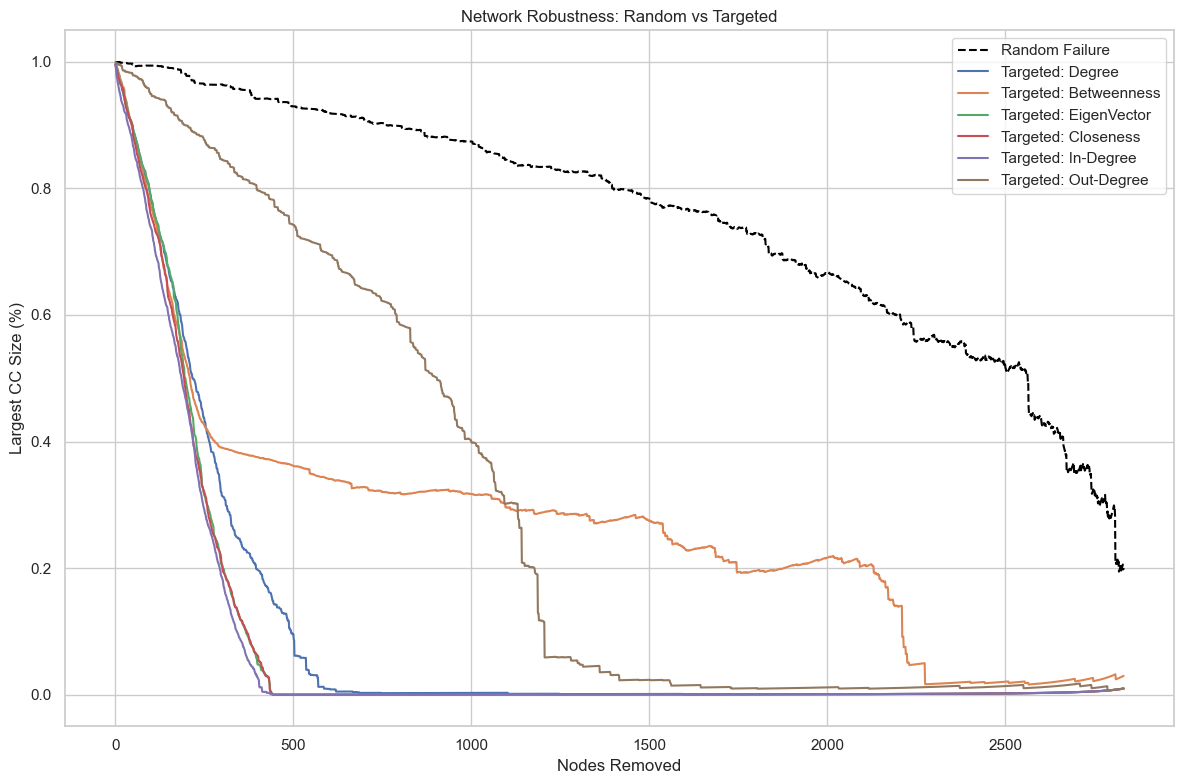

In [237]:
def largest_connected_component_size(G):
    if G.is_directed():
        comps = nx.weakly_connected_components(G)
    else:
        comps = nx.connected_components(G)
    largest_cc = max(comps, key=len)
    return len(largest_cc) / len(G.nodes) if G.nodes else 0

def simulate_random_failure(G, target_size=100):
    G_copy = G.copy()
    sizes = []
    nodes_to_remove = list(G_copy.nodes)
    random.shuffle(nodes_to_remove)

    for node in nodes_to_remove:
        G_copy.remove_node(node)
        sizes.append(largest_connected_component_size(G_copy))
        if len(G_copy.nodes) <= target_size:
            break
    return sizes

def simulate_targeted_attack(G, centrality_function, target_size=100):
    G_copy = G.copy()
    sizes = []
    cent = centrality_function(G_copy)
    sorted_nodes = sorted(cent.items(), key=lambda x: x[1], reverse=True)
    nodes_to_remove = [n for n, _ in sorted_nodes]

    for node in nodes_to_remove:
        G_copy.remove_node(node)
        sizes.append(largest_connected_component_size(G_copy))
        if len(G_copy.nodes) <= target_size:
            break
    return sizes

def plot_robustness_comparison(random_result, targeted_results, labels):
    plt.figure(figsize=(12,8))
    plt.plot(range(len(random_result)), random_result, label="Random Failure", linestyle="--", color="black")
    for result, label in zip(targeted_results, labels):
        plt.plot(range(len(result)), result, label=f"Targeted: {label}")
    plt.title("Network Robustness: Random vs Targeted")
    plt.xlabel("Nodes Removed")
    plt.ylabel("Largest CC Size (%)")
    plt.legend()
    plt.tight_layout()
    plt.savefig('plots/NetworkRobustness_RandomVSTargeted.png')
    plt.show()
    

centrality_functions = [
    ('Degree', nx.degree_centrality),
    ('Betweenness', nx.betweenness_centrality),
    ('EigenVector', nx.eigenvector_centrality),
    ('Closeness', nx.closeness_centrality),
    ('In-Degree', nx.in_degree_centrality),
    ('Out-Degree', nx.out_degree_centrality)
]

print("Simulating random failure...")
random_result = simulate_random_failure(G, target_size=100)
targeted_results = []

for label, func in centrality_functions:
    print(f"Simulating targeted attack for {label} centrality...")
    targeted_res = simulate_targeted_attack(G, func, target_size=100)
    targeted_results.append(targeted_res)

labels = [l for l, _ in centrality_functions]
plot_robustness_comparison(random_result, targeted_results, labels)


In [38]:
import networkx as nx
import pandas as pd
import numpy as np
from itertools import combinations
from sklearn.model_selection import train_test_split

def prepare_signed_edge_data(G_signed, test_size=0.2, random_state=42, negative_ratio=1.0):
    """
    Prepare data for signed edge prediction.
    
    Parameters:
        G_signed (networkx.Graph): The signed undirected graph.
        test_size (float): Proportion of the dataset to include in the test split.
        random_state (int): Seed for reproducibility.
        negative_ratio (float): Ratio of negative to positive samples.
    
    Returns:
        X_train, X_test, y_train, y_test: Split datasets.
    """
    # Extract positive and negative edges
    positive_edges = [(u, v) for u, v, d in G_signed.edges(data=True) if d.get('sign') == 1]
    negative_edges = [(u, v) for u, v, d in G_signed.edges(data=True) if d.get('sign') == -1]
    
    # Create labels
    pos_labels = [1] * len(positive_edges)
    neg_labels = [-1] * len(negative_edges)
    
    # Prepare positive samples
    pos_samples = positive_edges.copy()
    pos_labels = pos_labels.copy()
    
    # Prepare negative samples (non-existing edges)
    non_edges = list(nx.non_edges(G_signed))
    np.random.seed(random_state)
    sampled_non_edges = np.random.choice(len(non_edges), size=int(len(negative_edges) * negative_ratio), replace=False)
    sampled_non_edges = [non_edges[i] for i in sampled_non_edges]
    sampled_neg_labels = [0] * len(sampled_non_edges)  # Treating as no edge (optional: use -1)
    
    # Combine positive and negative samples
    X = pos_samples + sampled_non_edges
    y = pos_labels + sampled_neg_labels  # Use [1, 0] labels for classification
    
    # Convert to DataFrame for easier handling
    data = pd.DataFrame(X, columns=['SRC', 'TGT'])
    data['LABEL'] = y
    
    # Split into train and test sets
    train_data, test_data = train_test_split(data, test_size=test_size, random_state=random_state, stratify=data['LABEL'])
    
    # Extract features and labels
    X_train = train_data[['SRC', 'TGT']].values
    y_train = train_data['LABEL'].values
    X_test = test_data[['SRC', 'TGT']].values
    y_test = test_data['LABEL'].values
    
    return X_train, X_test, y_train, y_test

# Example usage:
# Assuming `G_undirected_signed` is your signed NetworkX graph
X_train, X_test, y_train, y_test = prepare_signed_edge_data(G_undirected_signed, test_size=0.2, negative_ratio=1.0)

print(f"Training samples: {len(X_train)}, Testing samples: {len(X_test)}")
print(f"Positive in training: {(y_train == 1).sum()}, Negative in training: {(y_train == 0).sum()}")
print(f"Positive in testing: {(y_test == 1).sum()}, Negative in testing: {(y_test == 0).sum()}")


Training samples: 23149, Testing samples: 5788
Positive in training: 17680, Negative in training: 5469
Positive in testing: 4420, Negative in testing: 1368


In [39]:
from sklearn.preprocessing import StandardScaler

def extract_features(G_signed, edge_pairs):
    """
    Extract structural features for given edge pairs.
    
    Parameters:
        G_signed (networkx.Graph): The signed graph.
        edge_pairs (list of tuples): List of (SRC, TGT) pairs.
    
    Returns:
        pd.DataFrame: DataFrame containing features for each edge pair.
    """
    features = []
    for u, v in edge_pairs:
        # Common neighbors
        common_neighbors = list(nx.common_neighbors(G_signed, u, v))
        pos_common = sum(1 for cn in common_neighbors if G_signed[u][cn]['sign'] == 1 and G_signed[v][cn]['sign'] == 1)
        neg_common = sum(1 for cn in common_neighbors if G_signed[u][cn]['sign'] == -1 or G_signed[v][cn]['sign'] == -1)
        
        # Preferential attachment
        degree_u = G_signed.degree(u)
        degree_v = G_signed.degree(v)
        preferential_attachment = degree_u * degree_v
        
        # Jaccard coefficient
        jaccard = len(common_neighbors) / len(set(G_signed.neighbors(u)).union(set(G_signed.neighbors(v)))) if len(set(G_signed.neighbors(u)).union(set(G_signed.neighbors(v)))) > 0 else 0
        
        # Add to features
        features.append({
            'common_neighbors': len(common_neighbors),
            'pos_common_neighbors': pos_common,
            'neg_common_neighbors': neg_common,
            'preferential_attachment': preferential_attachment,
            'jaccard_coefficient': jaccard
        })
    
    feature_df = pd.DataFrame(features)
    return feature_df

# Example usage:
# Extract features for training and testing sets
feature_train = extract_features(G_undirected_signed, X_train)
feature_test = extract_features(G_undirected_signed, X_test)

# Optional: Normalize features
scaler = StandardScaler()
feature_train_scaled = scaler.fit_transform(feature_train)
feature_test_scaled = scaler.transform(feature_test)


In [40]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# Prepare training and testing data
X_train_features = feature_train_scaled
X_test_features = feature_test_scaled
y_train_labels = y_train
y_test_labels = y_test

# Initialize Logistic Regression with class weights to handle imbalance
model = LogisticRegression(class_weight='balanced', random_state=42, max_iter=1000)

# Train the model
model.fit(X_train_features, y_train_labels)

# Predict on test set
y_pred = model.predict(X_test_features)
y_pred_proba = model.predict_proba(X_test_features)[:, 1]

# Evaluate the model
print("Confusion Matrix:")
print(confusion_matrix(y_test_labels, y_pred))

print("\nClassification Report:")
print(classification_report(y_test_labels, y_pred))

print(f"ROC-AUC Score: {roc_auc_score(y_test_labels, y_pred_proba):.4f}")


Confusion Matrix:
[[1321   47]
 [ 957 3463]]

Classification Report:
              precision    recall  f1-score   support

           0       0.58      0.97      0.72      1368
           1       0.99      0.78      0.87      4420

    accuracy                           0.83      5788
   macro avg       0.78      0.87      0.80      5788
weighted avg       0.89      0.83      0.84      5788

ROC-AUC Score: 0.9715


Matthews Correlation Coefficient (MCC): 0.6514
Balanced Accuracy: 0.8746
Precision-Recall AUC: 0.9890


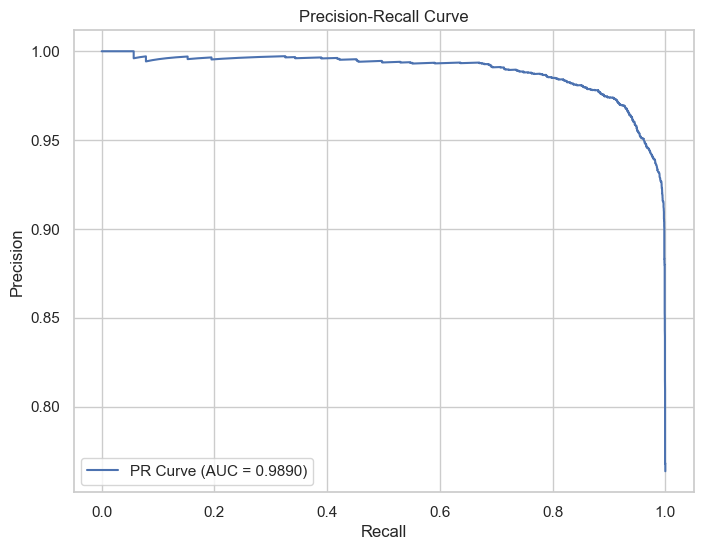

In [41]:
from sklearn.metrics import matthews_corrcoef, balanced_accuracy_score, precision_recall_curve, auc

# Calculate additional metrics
mcc = matthews_corrcoef(y_test_labels, y_pred)
balanced_acc = balanced_accuracy_score(y_test_labels, y_pred)

print(f"Matthews Correlation Coefficient (MCC): {mcc:.4f}")
print(f"Balanced Accuracy: {balanced_acc:.4f}")

# Precision-Recall Curve
precision, recall, thresholds = precision_recall_curve(y_test_labels, y_pred_proba)
pr_auc = auc(recall, precision)
print(f"Precision-Recall AUC: {pr_auc:.4f}")

# Plot Precision-Recall Curve
plt.figure(figsize=(8,6))
plt.plot(recall, precision, label=f'PR Curve (AUC = {pr_auc:.4f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()


In [49]:
import networkx as nx
import pandas as pd
import numpy as np
from itertools import combinations
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    matthews_corrcoef,
    balanced_accuracy_score,
    precision_recall_curve,
    auc
)
import matplotlib.pyplot as plt
from node2vec import Node2Vec

def create_signed_graph(df):
    """
    Create a MultiDiGraph from the DataFrame with edges labeled by interaction type (-1 or 1).
    """
    G = nx.MultiDiGraph()
    for _, row in df.iterrows():
        src, tgt, vot = row['SRC'], row['TGT'], row['VOT']
        txt, res, dat = row['TXT'], row['RES'], row['DAT']

        if vot not in [-1, 1]:
            continue

        if src not in G:
            G.add_node(src)
        if tgt not in G:
            G.add_node(tgt)

        admin_status = "admin" if res == 1 else "nonAdmin"
        edge_attrs = {'label': vot, 'txt': txt, 'admin': admin_status, 'DAT': dat}
        G.add_edge(src, tgt, **edge_attrs)
    return G

def convert_to_undirected_signed_graph(G_multi):
    """
    Convert a MultiDiGraph with signed edges to an undirected Graph by aggregating edge signs.
    Majority sign determines the aggregated edge sign.
    """
    G_signed = nx.Graph()
    for u, v, data in G_multi.edges(data=True):
        if u == v:
            continue  # Skip self-loops
        sign = data.get('label', 1)
        if G_signed.has_edge(u, v):
            # Update the sign based on majority
            current_sign = G_signed[u][v]['sign']
            new_sign = sign
            if current_sign == new_sign:
                G_signed[u][v]['count'] += 1
            else:
                G_signed[u][v]['count'] -= 1
                if G_signed[u][v]['count'] < 0:
                    G_signed[u][v]['sign'] = -1
                    G_signed[u][v]['count'] = abs(G_signed[u][v]['count'])
                else:
                    G_signed[u][v]['sign'] = 1
        else:
            G_signed.add_edge(u, v, sign=sign, count=1)
    return G_signed

def prepare_signed_edge_data(G_signed, test_size=0.2, random_state=42, negative_ratio=1.0):
    """
    Prepare data for signed edge prediction.

    Parameters:
        G_signed (networkx.Graph): The signed undirected graph.
        test_size (float): Proportion of the dataset to include in the test split.
        random_state (int): Seed for reproducibility.
        negative_ratio (float): Ratio of negative to positive samples.

    Returns:
        X_train, X_test, y_train, y_test: Split datasets.
    """
    # Extract positive and negative edges
    positive_edges = [(u, v) for u, v, d in G_signed.edges(data=True) if d.get('sign') == 1]
    negative_edges = [(u, v) for u, v, d in G_signed.edges(data=True) if d.get('sign') == -1]

    # Create labels
    pos_labels = [1] * len(positive_edges)
    neg_labels = [0] * len(negative_edges)  # Label 0 for no edge

    # Prepare positive samples
    pos_samples = positive_edges.copy()
    pos_labels = pos_labels.copy()

    # Prepare negative samples (non-existing edges)
    non_edges = list(nx.non_edges(G_signed))
    np.random.seed(random_state)
    sampled_non_edges = np.random.choice(len(non_edges), size=int(len(negative_edges) * negative_ratio), replace=False)
    sampled_non_edges = [non_edges[i] for i in sampled_non_edges]
    sampled_neg_labels = [0] * len(sampled_non_edges)

    # Combine positive and negative samples
    X = pos_samples + sampled_non_edges
    y = pos_labels + sampled_neg_labels

    # Convert to DataFrame for easier handling
    data = pd.DataFrame(X, columns=['SRC', 'TGT'])
    data['LABEL'] = y

    # Split into train and test sets
    train_data, test_data = train_test_split(data, test_size=test_size, random_state=random_state, stratify=data['LABEL'])

    # Extract features and labels
    X_train = train_data[['SRC', 'TGT']].values
    y_train = train_data['LABEL'].values
    X_test = test_data[['SRC', 'TGT']].values
    y_test = test_data['LABEL'].values

    return X_train, X_test, y_train, y_test

def extract_features(G_signed, edge_pairs):
    """
    Extract structural features for given edge pairs.

    Parameters:
        G_signed (networkx.Graph): The signed graph.
        edge_pairs (list of tuples): List of (SRC, TGT) pairs.

    Returns:
        pd.DataFrame: DataFrame containing features for each edge pair.
    """
    features = []
    for u, v in edge_pairs:
        # Common neighbors
        common_neighbors = list(nx.common_neighbors(G_signed, u, v))
        pos_common = sum(1 for cn in common_neighbors 
                         if G_signed[u][cn]['sign'] == 1 and G_signed[v][cn]['sign'] == 1)
        neg_common = sum(1 for cn in common_neighbors 
                         if G_signed[u][cn]['sign'] == -1 or G_signed[v][cn]['sign'] == -1)

        # Preferential attachment
        degree_u = G_signed.degree(u)
        degree_v = G_signed.degree(v)
        preferential_attachment = degree_u * degree_v

        # Jaccard coefficient
        union_neighbors = set(G_signed.neighbors(u)).union(set(G_signed.neighbors(v)))
        jaccard = len(common_neighbors) / len(union_neighbors) if len(union_neighbors) > 0 else 0

        # Balance feature: Number of balanced triads the edge is part of
        balanced_triads = 0
        for cn in common_neighbors:
            if G_signed.has_edge(u, cn) and G_signed.has_edge(v, cn):
                sign_uc = G_signed[u][cn]['sign']
                sign_vc = G_signed[v][cn]['sign']
                if G_signed.has_edge(u, v):
                    sign_uv = G_signed[u][v]['sign']
                else:
                    sign_uv = 0  # Default sign for non-existing edge

                # Balanced triad conditions:
                # 1. All three edges are positive
                # 2. Two edges are negative and one is positive
                if (sign_uc == 1 and sign_vc == 1 and sign_uv == 1) or \
                   (sign_uc == -1 and sign_vc == -1 and sign_uv == 1):
                    balanced_triads += 1

        features.append({
            'common_neighbors': len(common_neighbors),
            'pos_common_neighbors': pos_common,
            'neg_common_neighbors': neg_common,
            'preferential_attachment': preferential_attachment,
            'jaccard_coefficient': jaccard,
            'balanced_triads': balanced_triads
        })

    feature_df = pd.DataFrame(features)
    return feature_df

def generate_node_embeddings(G_signed, dimensions=64, walk_length=30, num_walks=200, workers=4):
    """
    Generate node embeddings using Node2Vec.
    Adapted to handle compatibility with Gensim 4.x.

    Parameters:
        G_signed (networkx.Graph): The signed graph.
        dimensions (int): Embedding dimensions.
        walk_length (int): Length of each random walk.
        num_walks (int): Number of walks per node.
        workers (int): Number of parallel workers.

    Returns:
        dict: Node to embedding mapping.
    """
    # Convert signed graph to unsigned for Node2Vec
    G_unsigned = G_signed.copy()
    for u, v, d in G_unsigned.edges(data=True):
        G_unsigned[u][v].pop('sign', None)
        G_unsigned[u][v].pop('count', None)

    node2vec_model = Node2Vec(
        G_unsigned,
        dimensions=dimensions,
        walk_length=walk_length,
        num_walks=num_walks,
        workers=workers,
        quiet=True
    )

    # Attempt to fit the model with 'vector_size' parameter
    try:
        model = node2vec_model.fit(window=10, min_count=1, batch_words=4, vector_size=dimensions)
    except TypeError as e:
        print(f"TypeError during Node2Vec fitting: {e}")
        print("Attempting to fit without specifying 'size' parameter.")
        model = node2vec_model.fit(window=10, min_count=1, batch_words=4)

    # Create embedding matrix
    embeddings = {}
    for node in G_signed.nodes():
        try:
            embeddings[node] = model.wv[str(node)]
        except KeyError:
            # Handle nodes without embeddings
            embeddings[node] = np.zeros(dimensions)
    
    return embeddings

def incorporate_embeddings(X, embeddings, embedding_dim=64):
    """
    Incorporate node embeddings into feature vectors for edge pairs.

    Parameters:
        X (np.array): Array of edge pairs.
        embeddings (dict): Node to embedding mapping.
        embedding_dim (int): Dimension of embeddings.

    Returns:
        np.array: Feature vectors with concatenated embeddings.
    """
    feature_vectors = []
    for u, v in X:
        emb_u = embeddings.get(u, np.zeros(embedding_dim))
        emb_v = embeddings.get(v, np.zeros(embedding_dim))
        combined = np.concatenate([emb_u, emb_v])
        feature_vectors.append(combined)
    return np.array(feature_vectors)

def train_evaluate_model(X_train_features, y_train, X_test_features, y_test):
    """
    Train a Logistic Regression model and evaluate its performance.

    Parameters:
        X_train_features (np.array): Training features.
        y_train (np.array): Training labels.
        X_test_features (np.array): Testing features.
        y_test (np.array): Testing labels.

    Returns:
        model: Trained Logistic Regression model.
        metrics: Dictionary of evaluation metrics.
    """
    # Initialize Logistic Regression with class weights to handle imbalance
    model = LogisticRegression(class_weight='balanced', random_state=42, max_iter=1000)

    # Train the model
    model.fit(X_train_features, y_train)

    # Predict on test set
    y_pred = model.predict(X_test_features)
    y_pred_proba = model.predict_proba(X_test_features)[:, 1]

    # Calculate metrics
    conf_matrix = confusion_matrix(y_test, y_pred)
    class_report = classification_report(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    mcc = matthews_corrcoef(y_test, y_pred)
    balanced_acc = balanced_accuracy_score(y_test, y_pred)

    # Precision-Recall Curve
    precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba)
    pr_auc = auc(recall, precision)

    # Compile metrics
    metrics = {
        'confusion_matrix': conf_matrix,
        'classification_report': class_report,
        'roc_auc_score': roc_auc,
        'mcc': mcc,
        'balanced_accuracy': balanced_acc,
        'precision_recall_auc': pr_auc
    }

    # Print metrics
    print("Confusion Matrix:")
    print(conf_matrix)

    print("\nClassification Report:")
    print(class_report)

    print(f"ROC-AUC Score: {roc_auc:.4f}")
    print(f"Matthews Correlation Coefficient (MCC): {mcc:.4f}")
    print(f"Balanced Accuracy: {balanced_acc:.4f}")
    print(f"Precision-Recall AUC: {pr_auc:.4f}")

    # Plot Precision-Recall Curve
    plt.figure(figsize=(8,6))
    plt.plot(recall, precision, label=f'PR Curve (AUC = {pr_auc:.4f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve with Embeddings')
    plt.legend()
    plt.show()

    return model, metrics

def edge_prediction_workflow(df):
    """
    Complete workflow for signed edge prediction.

    Parameters:
        df (pd.DataFrame): DataFrame containing edge data with columns ['SRC', 'TGT', 'VOT', 'TXT', 'RES', 'DAT']

    Returns:
        None
    """
    # Step 1: Create signed graph
    G_multi = create_signed_graph(df)

    # Step 2: Convert to undirected signed graph
    G_signed = convert_to_undirected_signed_graph(G_multi)

    # Ensure all node labels are strings
    G_signed = nx.relabel_nodes(G_signed, lambda x: str(x) if not isinstance(x, str) else x)

    print(f"Converted to Undirected Signed Graph:")
    print(f"Number of Nodes: {G_signed.number_of_nodes()}")
    print(f"Number of Edges: {G_signed.number_of_edges()}")

    # Recalculate positive and negative edges after conversion
    pos_edges = sum(1 for u, v, d in G_signed.edges(data=True) if d.get("sign") == 1)
    neg_edges = sum(1 for u, v, d in G_signed.edges(data=True) if d.get("sign") == -1)
    total_edges = G_signed.number_of_edges()
    pos_ratio = (pos_edges / total_edges) * 100 if total_edges > 0 else 0
    neg_ratio = (neg_edges / total_edges) * 100 if total_edges > 0 else 0

    print(f"Positive edges: {pos_edges} ({pos_ratio:.2f}%)")
    print(f"Negative edges: {neg_edges} ({neg_ratio:.2f}%)")

    # Step 3: Prepare edge prediction data
    X_train, X_test, y_train, y_test = prepare_signed_edge_data(G_signed, test_size=0.2, random_state=42, negative_ratio=1.0)

    print(f"Training samples: {len(X_train)}, Testing samples: {len(X_test)}")
    print(f"Positive in training: {(y_train == 1).sum()}, Negative in training: {(y_train == 0).sum()}")
    print(f"Positive in testing: {(y_test == 1).sum()}, Negative in testing: {(y_test == 0).sum()}")

    # Step 4: Extract structural features
    feature_train = extract_features(G_signed, X_train)
    feature_test = extract_features(G_signed, X_test)

    # Step 5: Normalize features
    scaler = StandardScaler()
    feature_train_scaled = scaler.fit_transform(feature_train)
    feature_test_scaled = scaler.transform(feature_test)

    # Step 6: Generate node embeddings
    embeddings = generate_node_embeddings(G_signed, dimensions=64, walk_length=30, num_walks=200, workers=4)

    # Step 7: Incorporate embeddings
    X_train_emb = incorporate_embeddings(X_train, embeddings, embedding_dim=64)
    X_test_emb = incorporate_embeddings(X_test, embeddings, embedding_dim=64)

    # Step 8: Combine structural features and embeddings
    X_train_combined = np.hstack((feature_train_scaled, X_train_emb))
    X_test_combined = np.hstack((feature_test_scaled, X_test_emb))

    # Step 9: Train and evaluate model
    model, metrics = train_evaluate_model(X_train_combined, y_train, X_test_combined, y_test)

    # (Optional) Feature Importance Visualization
    importances = model.coef_[0]
    # Assuming first len(feature_train.columns) are structural features, rest are embeddings
    structural_importances = importances[:feature_train.shape[1]]
    embedding_importances = importances[feature_train.shape[1]:]

    feature_names_struct = feature_train.columns.tolist()
    feature_names_emb = [f'emb_{i+1}' for i in range(X_train_emb.shape[1])]

    feature_importance_struct = pd.Series(structural_importances, index=feature_names_struct).sort_values(ascending=False)
    feature_importance_emb = pd.Series(embedding_importances, index=feature_names_emb).sort_values(ascending=False)

    # Plot Structural Feature Importances
    plt.figure(figsize=(10,6))
    feature_importance_struct.head(10).plot(kind='bar')
    plt.title('Top 10 Structural Feature Importances')
    plt.ylabel('Coefficient Value')
    plt.show()

    # Plot Embedding Feature Importances
    plt.figure(figsize=(10,6))
    feature_importance_emb.head(10).plot(kind='bar')
    plt.title('Top 10 Embedding Feature Importances')
    plt.ylabel('Coefficient Value')
    plt.show()

    print("\nTop 5 Structural Features Influencing Edge Prediction:")
    print(feature_importance_struct.head(5))

    print("\nTop 5 Embedding Features Influencing Edge Prediction:")
    print(feature_importance_emb.head(5))


In [50]:
# Run the corrected edge prediction workflow
edge_prediction_workflow(df)


Converted to Undirected Signed Graph:
Number of Nodes: 2934
Number of Edges: 28937
Positive edges: 22100 (76.37%)
Negative edges: 6837 (23.63%)
Training samples: 23149, Testing samples: 5788
Positive in training: 17680, Negative in training: 5469
Positive in testing: 4420, Negative in testing: 1368
TypeError during Node2Vec fitting: Word2Vec.__init__() got an unexpected keyword argument 'size'
Attempting to fit without specifying 'size' parameter.


TypeError: Word2Vec.__init__() got an unexpected keyword argument 'size'

In [244]:
df

,SRC,TGT,VOT,RES,YEA,DAT,TXT,cleaned_TXT
0,Steel1943,BDD,1,1,2013,2013-04-19 23:13:00,'''''' as co-nom.,co
1,Cuchullain,BDD,1,1,2013,2013-04-20 01:04:00,'''''' as nominator.--,nominator
2,INeverCry,BDD,1,1,2013,2013-04-19 23:43:00,'''''' per noms.,noms
3,Cncmaster,BDD,1,1,2013,2013-04-20 00:11:00,'''''' per noms. BDD is a strong contributor w...,noms bdd strong contributor thousand edits yea...
4,Miniapolis,BDD,1,1,2013,2013-04-20 00:56:00,"'''''', with great pleasure. I work with BDD a...",great pleasure work bdd coordinator seen good ...
...,...,...,...,...,...,...,...,...
32305,Atama,ZooPro,-1,-1,2010,2010-02-22 18:17:00,"'''''' - Per Polargeo, and per [http://en.wiki...",polargeo deal killer someone want work deletio...
32306,Bradjamesbrown,ZooPro,-1,-1,2010,2010-02-22 18:18:00,'''''' per SilkTork's diff above. Asserting [[...,silktork asserting article portal good behavio...
32307,Ottawa4ever,ZooPro,0,-1,2010,2010-02-22 18:11:00,"'''''' Not to pile on, neutral. I cannot suppo...",pile neutral support smithers pointed feeding ...
32308,Tryptofish,ZooPro,0,-1,2010,2010-02-22 17:58:00,'''''' I've interacted with this editor at var...,interacted editor various animal related page ...


In [246]:
import re
import pandas as pd
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer, PorterStemmer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
import networkx as nx

# Instantiate Lemmatizer and Stemmer
lmtzr = WordNetLemmatizer()
porter = PorterStemmer()
stop_words = set(stopwords.words('english') + ['support', 'oppose', 'user', 'admin', 'candidate', 'wikipedia', 'color',
                                              'http', 'php', 'org', 'luck', 'font', 'see', 'green', 'would', 'e', 'span', 'style', 'border', '1px', 'index'])

# Function to get text in desired lowercase form
def abbr_or_lower(word):
    if re.match('([A-Z]+[a-z]*){2,}', word):
        return word
    else:
        return word.lower()

# Function for different forms of tokenization (all 3 forms tested for performance)
def tokenize(words, modulation):
    tokens = re.split(r'\W+', words)
    stems = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        lowers = abbr_or_lower(token)
        if lowers not in stop_words:
            if re.search('[a-zA-Z]', lowers):
                if modulation == 1:
                    stems.append(porter.stem(lowers))
                if modulation == 2:
                    stems.append(lmtzr.lemmatize(lowers))
                if modulation == 0:
                    stems.append(lowers)
    return stems

# Ensure that the 'TXT' column is in string format and handle NaN values by replacing them with an empty string
df['TXT'] = df['TXT'].fillna('').astype(str)

# Create a directed graph where edges are defined by the SRC (voter) and TGT (voted-for user) columns
G = nx.DiGraph()


# Calculate in-degree centrality
in_degree_centrality = nx.in_degree_centrality(G)

# Sort the in-degree centrality and get the top 10 users
top_10_in_degree_users = [user for user, _ in sorted(in_degree_centrality.items(), key=lambda item: item[1], reverse=True)[:10]]

# Filter the dataframe for comments from top 10 in-degree users
df_top_10 = df[df['SRC'].isin(top_10_in_degree_users)]  # Filter by 'SRC' for users who voted

# Ensure that the 'cleaned_TXT' column is in string format and handle NaN values by replacing them with an empty string
df_top_10['cleaned_TXT'] = df_top_10['cleaned_TXT'].fillna('').astype(str)

# Create an empty dictionary to store results for each user
user_tfidf_results = {}

# Loop through the top 10 in-degree users and apply TF-IDF for each user's comments
for user in top_10_in_degree_users:
    # Filter comments for the current user
    user_comments = df_top_10[df_top_10['SRC'] == user]['cleaned_TXT']
    
    # Apply Pre-Processing and Tokenization
    comments_tokenized = [tokenize(comment, 2) for comment in user_comments]  # Modulation = 2 for lemmatization
    
    # Instantiate TF-IDF Vectorizer
    tfidf = TfidfVectorizer(ngram_range=(1, 1), tokenizer=lambda doc: doc, lowercase=False)  # Unigrams
    
    # Compute TF-IDF for the user's comments
    tfidf_matrix = tfidf.fit_transform(comments_tokenized)
    
    # Convert the results into a DataFrame for better readability
    tfidf_df = pd.DataFrame.sparse.from_spmatrix(tfidf_matrix, columns=tfidf.get_feature_names_out())
    tfidf_df = tfidf_df.sum(axis=0)  # Sum across all documents (rows)
    tfidf_df = tfidf_df.sort_values(axis=0, ascending=False)  # Sort by frequency
    
    # Store the results in the dictionary
    user_tfidf_results[user] = tfidf_df
    
    # Print the top terms for this user
    print(f"Top Unigrams for User {user}:")
    print(tfidf_df.head(10))  # Print top 10 unigrams for each user
    print("\n")

# Now, `user_tfidf_results` contains the TF-IDF results for each user.


/var/folders/dd/q59hq4f165zf1s43dyw9y7d80000gn/T/ipykernel_3529/2243081130.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_top_10['cleaned_TXT'] = df_top_10['cleaned_TXT'].fillna('').astype(str)
/opt/anaconda3/envs/ADC/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/anaconda3/envs/ADC/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/anaconda3/envs/ADC/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be use

Top Unigrams for User HJ Mitchell:
think         6.413288
editor        5.353152
good          4.966433
work          4.934855
make          4.437843
experience    4.306694
time          4.252547
area          3.966263
admins         3.94033
like          3.887783
dtype: Sparse[float64, 0]


Top Unigrams for User SarahStierch:
yes             0.641902
contribution    0.628018
mop             0.539267
always          0.489197
good            0.475521
wiki            0.432546
work            0.432546
pleasure        0.432546
please          0.432546
bilby           0.419871
dtype: Sparse[float64, 0]


Top Unigrams for User Ironholds:
strong            4.685253
excellent         4.044336
great             3.007842
good               2.90273
seems             2.101321
trust             1.949253
yes               1.816475
reason            1.749825
editor            1.681159
wholeheartedly    1.342021
dtype: Sparse[float64, 0]


Top Unigrams for User Drmies:
editor          3.627342
one    

/opt/anaconda3/envs/ADC/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/anaconda3/envs/ADC/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/anaconda3/envs/ADC/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/anaconda3/envs/ADC/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/anaconda3/envs/ADC/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.w

Top Unigrams for User Lord Roem:
concern      3.722192
qualified    2.926354
answer       2.865833
great        2.773113
good         2.538727
look         2.527763
best         2.527341
question      2.13548
editor       2.029437
well         1.654736
dtype: Sparse[float64, 0]


Top Unigrams for User Connormah:
good        10.091497
look         5.422019
great         4.10631
sure         3.718397
work         3.127239
helpful      2.311071
sorry        2.210646
net          2.136654
positive     2.136654
finally           2.0
dtype: Sparse[float64, 0]


Top Unigrams for User Everyking:
good          1.216059
editor        1.115632
clearly       1.115632
work          0.769449
concern       0.707107
judgment      0.707107
excellent     0.648465
conduct        0.57735
outrageous     0.57735
strong         0.57735
dtype: Sparse[float64, 0]


Top Unigrams for User Elen of the Roads:
good         2.295143
chap         1.461588
answer       1.449144
thing        1.309192
excellent    1.258

In [8]:
import re
import pandas as pd
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer, PorterStemmer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
import networkx as nx

# Instantiate Lemmatizer and Stemmer
lmtzr = WordNetLemmatizer()
porter = PorterStemmer()
stop_words = set(stopwords.words('english') + [
    'support', 'oppose', 'user', 'admin', 'candidate', 'wikipedia', 'color',
    'http', 'php', 'org', 'luck', 'font', 'see', 'green', 'would', 'e',
    'span', 'style', 'border', '1px', 'index'
])

# Function to get text in desired lowercase form
def abbr_or_lower(word):
    if re.match('([A-Z]+[a-z]*){2,}', word):
        return word
    else:
        return word.lower()

# Function for tokenization with stemming or lemmatization
def tokenize(words, modulation):
    tokens = re.split(r'\W+', words)
    stems = []
    # Filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        lowers = abbr_or_lower(token)
        if lowers not in stop_words:
            if re.search('[a-zA-Z]', lowers):
                if modulation == 1:
                    stems.append(porter.stem(lowers))
                elif modulation == 2:
                    stems.append(lmtzr.lemmatize(lowers))
                else:
                    stems.append(lowers)
    return stems

# Ensure that the 'TXT' and 'cleaned_TXT' columns are in string format and handle NaN values
df['TXT'] = df['TXT'].fillna('').astype(str)
df['cleaned_TXT'] = df['cleaned_TXT'].fillna('').astype(str)



# Calculate in-degree centrality
in_degree_centrality = nx.in_degree_centrality(G)

# Sort the in-degree centrality and get the top 10 users
top_10_in_degree_users = [user for user, _ in sorted(in_degree_centrality.items(), key=lambda item: item[1], reverse=True)[:10]]

# Filter the dataframe for comments from top 10 in-degree users
df_top_10 = df[df['SRC'].isin(top_10_in_degree_users)]  # Filter by 'SRC' for users who voted

# Ensure that the 'cleaned_TXT' column is in string format and handle NaN values by replacing them with an empty string
df_top_10['cleaned_TXT'] = df_top_10['cleaned_TXT'].fillna('').astype(str)

# Create a dictionary to store TF-IDF results for each user
user_tfidf_results = {}

# Loop through each top 10 user to perform separate TF-IDF analyses
for user in top_10_in_degree_users:
    # Filter comments for the current user
    user_comments = df_top_10[df_top_10['SRC'] == user]['cleaned_TXT']
    
    # Apply Pre-Processing and Tokenization
    comments_tokenized = [tokenize(comment, 2) for comment in user_comments]  # Modulation = 2 for lemmatization
    
    # Instantiate TF-IDF Vectorizer for Unigrams, Bigrams, and Trigrams
    tfidf_unigram = TfidfVectorizer(ngram_range=(1, 1), tokenizer=lambda doc: doc, lowercase=False)
    tfidf_bigram = TfidfVectorizer(ngram_range=(2, 2), tokenizer=lambda doc: doc, lowercase=False)
    tfidf_trigram = TfidfVectorizer(ngram_range=(3, 3), tokenizer=lambda doc: doc, lowercase=False)
    
    # Compute TF-IDF for Unigrams
    tfidf_matrix_unigram = tfidf_unigram.fit_transform(comments_tokenized)
    tfidf_df_unigram = pd.DataFrame.sparse.from_spmatrix(tfidf_matrix_unigram, columns=tfidf_unigram.get_feature_names_out())
    tfidf_df_unigram = tfidf_df_unigram.sum(axis=0).sort_values(ascending=False)
    
    # Compute TF-IDF for Bigrams
    tfidf_matrix_bigram = tfidf_bigram.fit_transform(comments_tokenized)
    tfidf_df_bigram = pd.DataFrame.sparse.from_spmatrix(tfidf_matrix_bigram, columns=tfidf_bigram.get_feature_names_out())
    tfidf_df_bigram = tfidf_df_bigram.sum(axis=0).sort_values(ascending=False)
    
    # Compute TF-IDF for Trigrams
    tfidf_matrix_trigram = tfidf_trigram.fit_transform(comments_tokenized)
    tfidf_df_trigram = pd.DataFrame.sparse.from_spmatrix(tfidf_matrix_trigram, columns=tfidf_trigram.get_feature_names_out())
    tfidf_df_trigram = tfidf_df_trigram.sum(axis=0).sort_values(ascending=False)
    
    # Store the results in the dictionary
    user_tfidf_results[user] = {
        'Unigrams': tfidf_df_unigram.head(10),
        'Bigrams': tfidf_df_bigram.head(10),
        'Trigrams': tfidf_df_trigram.head(10)
    }
    
    # Print the top terms for this user
    print(f"\nTop Unigrams for User {user}:")
    print(user_tfidf_results[user]['Unigrams'])
    
    print(f"\nTop Bigrams for User {user}:")
    print(user_tfidf_results[user]['Bigrams'])
    
    print(f"\nTop Trigrams for User {user}:")
    print(user_tfidf_results[user]['Trigrams'])

# Create a dictionary to store admin status for each top user
user_admin_status = {}

# Loop through each top 10 user to check if they are admins
for user in top_10_in_degree_users:
    if user in G.nodes:
        status = G.nodes[user].get('admin', 'Unknown')
    else:
        status = 'Unknown'
    user_admin_status[user] = status

# Print out the admin status for each user
print("\nAdmin Status of Top 10 In-Degree Users:")
for user, status in user_admin_status.items():
    print(f"User {user} is {status}.")

# Calculate the proportion of support votes for each top user
user_support_proportion = {}

for user in top_10_in_degree_users:
    # Get the user's votes from the dataframe
    user_votes = df_top_10[df_top_10['SRC'] == user]
    
    # Calculate the total number of votes (support + oppose)
    total_votes = user_votes.shape[0]
    
    # Calculate the number of support votes
    support_votes = user_votes[user_votes['VOT'] == 1].shape[0]
    
    # Calculate the proportion of support votes
    if total_votes > 0:
        support_proportion = support_votes / total_votes
    else:
        support_proportion = 0  # If no votes, proportion is 0
    
    # Store the result for this user
    user_support_proportion[user] = support_proportion

# Print out the support proportion for each user
print("\nProportion of Support Votes for Top 10 In-Degree Users:")
for user, proportion in user_support_proportion.items():
    print(f"User {user} has a support vote proportion of {proportion:.2f}.")


/var/folders/dd/q59hq4f165zf1s43dyw9y7d80000gn/T/ipykernel_9853/2051774964.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_top_10['cleaned_TXT'] = df_top_10['cleaned_TXT'].fillna('').astype(str)
/opt/anaconda3/envs/ADC/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/anaconda3/envs/ADC/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/anaconda3/envs/ADC/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be use


Top Unigrams for User HJ Mitchell:
think         6.413288
editor        5.353152
good          4.966433
work          4.934855
make          4.437843
experience    4.306694
time          4.252547
area          3.966263
admins         3.94033
like          3.887783
dtype: Sparse[float64, 0]

Top Bigrams for User HJ Mitchell:
answer question    2.097214
good job           1.418933
need admins        1.378694
year ago           1.322417
net positive       1.299396
want work          1.299352
think good         1.209772
reason think       1.193619
best friend        1.145583
short area         1.083902
dtype: Sparse[float64, 0]

Top Trigrams for User HJ Mitchell:
think good job           1.114951
pending answer q              1.0
looking forward best          1.0
absolutely year ago           1.0
esteem hold nominator    0.863312
reason think good        0.852862
work short area          0.833684
took long enough         0.707107
long enough bully        0.707107
think net positive       

/opt/anaconda3/envs/ADC/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/anaconda3/envs/ADC/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/anaconda3/envs/ADC/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/anaconda3/envs/ADC/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/anaconda3/envs/ADC/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.w


Top Unigrams for User SarekOfVulcan:
answer       4.30863
reason      3.853159
tool        3.552338
think       3.408701
good        3.026686
question    2.869045
abuse        2.15222
clueful      2.14334
oh          1.883709
work        1.772427
dtype: Sparse[float64, 0]

Top Bigrams for User SarekOfVulcan:
reason think         3.019658
answer question      2.551447
good answer          2.027047
think abuse          1.864824
abuse tool           1.746542
generally clueful    1.313593
clueful reason       1.303583
trusted mop          1.074662
think trusted        1.074662
oh already                1.0
dtype: Sparse[float64, 0]

Top Trigrams for User SarekOfVulcan:
reason think abuse          2.063492
think abuse tool            1.953461
think trusted mop           1.136862
reason think trusted        1.136862
generally clueful reason    1.116414
oh hell yeah                     1.0
strong answer q3                 1.0
answer question feyd             1.0
vote romney unconvincing     

/opt/anaconda3/envs/ADC/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/anaconda3/envs/ADC/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(



Top Unigrams for User Drmies:
editor          3.627342
one             2.613161
good            2.581321
also            2.495153
think           2.475877
well            2.115103
article         2.052573
contribution    1.939828
like             1.74247
work            1.598686
dtype: Sparse[float64, 0]

Top Bigrams for User Drmies:
tide roll               1.0
random editor           1.0
also vonian             1.0
level headed       0.714545
yes clear          0.707107
oh yes             0.707107
think fine         0.615198
overdue telling     0.57735
long overdue        0.57735
telling tide        0.57735
dtype: Sparse[float64, 0]

Top Trigrams for User Drmies:
oh yes clear                        1.0
long overdue telling           0.707107
overdue telling tide           0.707107
editor intellect competence         0.5
editor right temperament            0.5
well known blp                      0.5
one think editor                    0.5
quality editor intellect            0.5
well d

/opt/anaconda3/envs/ADC/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/anaconda3/envs/ADC/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/anaconda3/envs/ADC/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/anaconda3/envs/ADC/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [7]:
# Create a dictionary to store admin status for each top user
user_admin_status = {}

# Loop through each top 10 user to check if they are admins
for user in top_10_in_degree_users:
    if user in G.nodes:
        status = G.nodes[user].get('admin', 'Unknown')
    else:
        status = 'Unknown'
    user_admin_status[user] = status

# Print out the admin status for each user
print("\nAdmin Status of Top 10 In-Degree Users:")
for user, status in user_admin_status.items():
    print(f"User {user} is {status}.")

# Calculate the proportion of support votes for each top user
user_support_proportion = {}

for user in top_10_in_degree_users:
    # Get the user's votes from the dataframe
    user_votes = df_top_10[df_top_10['SRC'] == user]
    
    # Calculate the total number of votes (support + oppose)
    total_votes = user_votes.shape[0]
    
    # Calculate the number of support votes
    support_votes = user_votes[user_votes['VOT'] == 1].shape[0]
    
    # Calculate the proportion of support votes
    if total_votes > 0:
        support_proportion = support_votes / total_votes
    else:
        support_proportion = 0  # If no votes, proportion is 0
    
    # Store the result for this user
    user_support_proportion[user] = support_proportion

# Print out the support proportion for each user
print("\nProportion of Support Votes for Top 10 In-Degree Users:")
for user, proportion in user_support_proportion.items():
    print(f"User {user} has a support vote proportion of {proportion:.2f}.")



Admin Status of Top 10 In-Degree Users:
User HJ Mitchell is admin.
User Ironholds is admin.
User Everyking is admin.
User SarekOfVulcan is admin.
User The Thing That Should Not Be is nonAdmin.
User Connormah is admin.
User SarahStierch is admin.
User Lord Roem is admin.
User Drmies is admin.
User Σ is nonAdmin.


NameError: name 'df_top_10' is not defined

### Top 10 In-Degree Nodes and Their RfA Runs ###

                        User  In-Degree Centrality  Number of RfA Runs Years of RfA Runs
                 HJ Mitchell              0.101786                 341        2010, 2011
                   Ironholds              0.088642                 294        2010, 2011
The Thing That Should Not Be              0.081227                 265              2010
               SarekOfVulcan              0.079879                 237              2011
                   Everyking              0.079205                 239              2010
                   Connormah              0.078868                 326              2010
                SarahStierch              0.073475                 218              2012
                           Σ              0.073138                 217              2012
                   Lord Roem              0.072464                 272        2012, 2013
                      Drmies              0.070104         

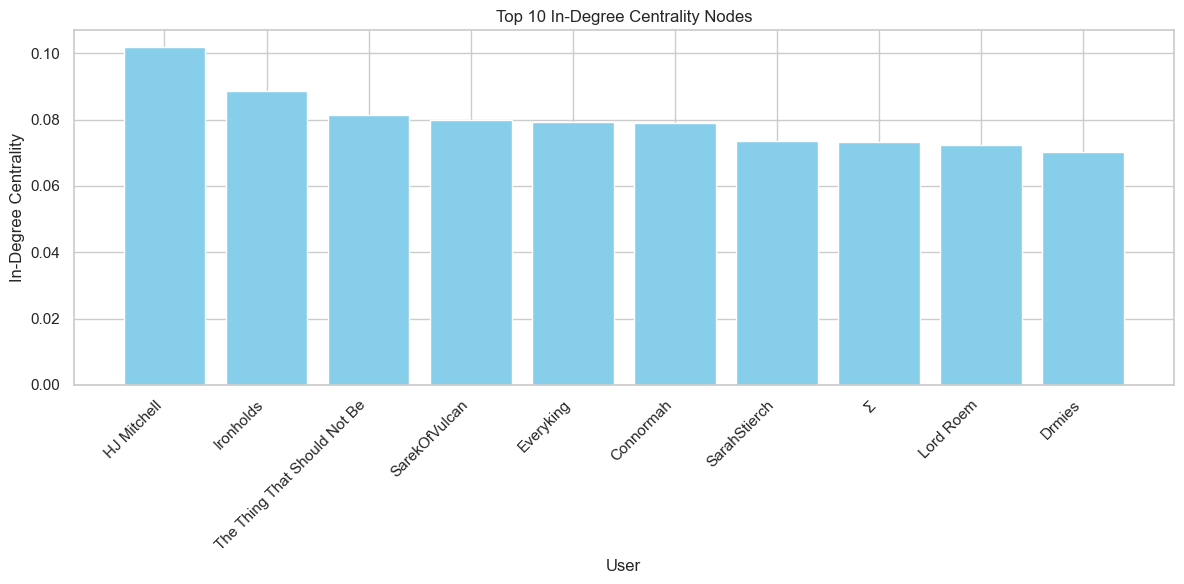


Results have been saved to 'top_10_in_degree_rfa_runs.csv'


In [9]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

# 1. Import Necessary Libraries
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

# 2. Prepare the DataFrame
# Replace the following line with your actual data loading method
# For example: df = pd.read_csv('your_data.csv')
# Here, we'll assume 'df' is already loaded

# Ensure that the 'DAT' column is in datetime format
df['DAT'] = pd.to_datetime(df['DAT'], errors='coerce')

# Drop rows with invalid dates if any
df = df.dropna(subset=['DAT'])

# 3. Create a Directed Graph using NetworkX
G = nx.DiGraph()

# Add edges to the graph from the DataFrame
G.add_edges_from(zip(df['SRC'], df['TGT']))

# 4. Calculate In-Degree Centrality
in_degree_centrality = nx.in_degree_centrality(G)

# 5. Identify the Top 10 In-Degree Nodes
sorted_in_degree = sorted(in_degree_centrality.items(), key=lambda item: item[1], reverse=True)
top_10_in_degree = sorted_in_degree[:10]
top_10_users = [user for user, centrality in top_10_in_degree]

# 6. Count the Number of RfA Runs (`TGT`) for Each Top Node
results = []

for user, centrality in top_10_in_degree:
    user_rfa_runs = df[df['TGT'] == user]
    rfa_count = user_rfa_runs.shape[0]
    years = user_rfa_runs['DAT'].dt.year.unique()
    years_sorted = sorted(years)
    results.append({
        'User': user,
        'In-Degree Centrality': centrality,
        'Number of RfA Runs': rfa_count,
        'Years of RfA Runs': ', '.join(map(str, years_sorted))
    })

# 7. Display the Results in a Structured Table
results_df = pd.DataFrame(results)
results_df = results_df.sort_values(by='In-Degree Centrality', ascending=False).reset_index(drop=True)

print("### Top 10 In-Degree Nodes and Their RfA Runs ###\n")
print(results_df.to_string(index=False))

# Optional: Visualization
plt.figure(figsize=(12, 6))
plt.bar(results_df['User'], results_df['In-Degree Centrality'], color='skyblue')
plt.title('Top 10 In-Degree Centrality Nodes')
plt.xlabel('User')
plt.ylabel('In-Degree Centrality')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Optional: Save the results to a CSV file
results_df.to_csv('top_10_in_degree_rfa_runs.csv', index=False)
print("\nResults have been saved to 'top_10_in_degree_rfa_runs.csv'")


[nltk_data] Downloading package punkt to /Users/dan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/dan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Top 10 In-Degree Nodes ###

1. HJ Mitchell - In-Degree Centrality: 0.0958
2. Ironholds - In-Degree Centrality: 0.0852
3. Everyking - In-Degree Centrality: 0.0781
4. SarekOfVulcan - In-Degree Centrality: 0.0774
5. The Thing That Should Not Be - In-Degree Centrality: 0.0760
6. Connormah - In-Degree Centrality: 0.0753
7. SarahStierch - In-Degree Centrality: 0.0736
8. Lord Roem - In-Degree Centrality: 0.0716
9. Drmies - In-Degree Centrality: 0.0699
10. Σ - In-Degree Centrality: 0.0682

### Proportion of Votes per User per Year ###

                        User  Year  Positive Votes (%)  Negative Votes (%)  Total Votes
                 HJ Mitchell  2010               85.50               14.50          131
                 HJ Mitchell  2011               89.62               10.38          183
                   Ironholds  2010               63.11               36.89          103
                   Ironholds  2011               96.51                3.49          172
                   Eve

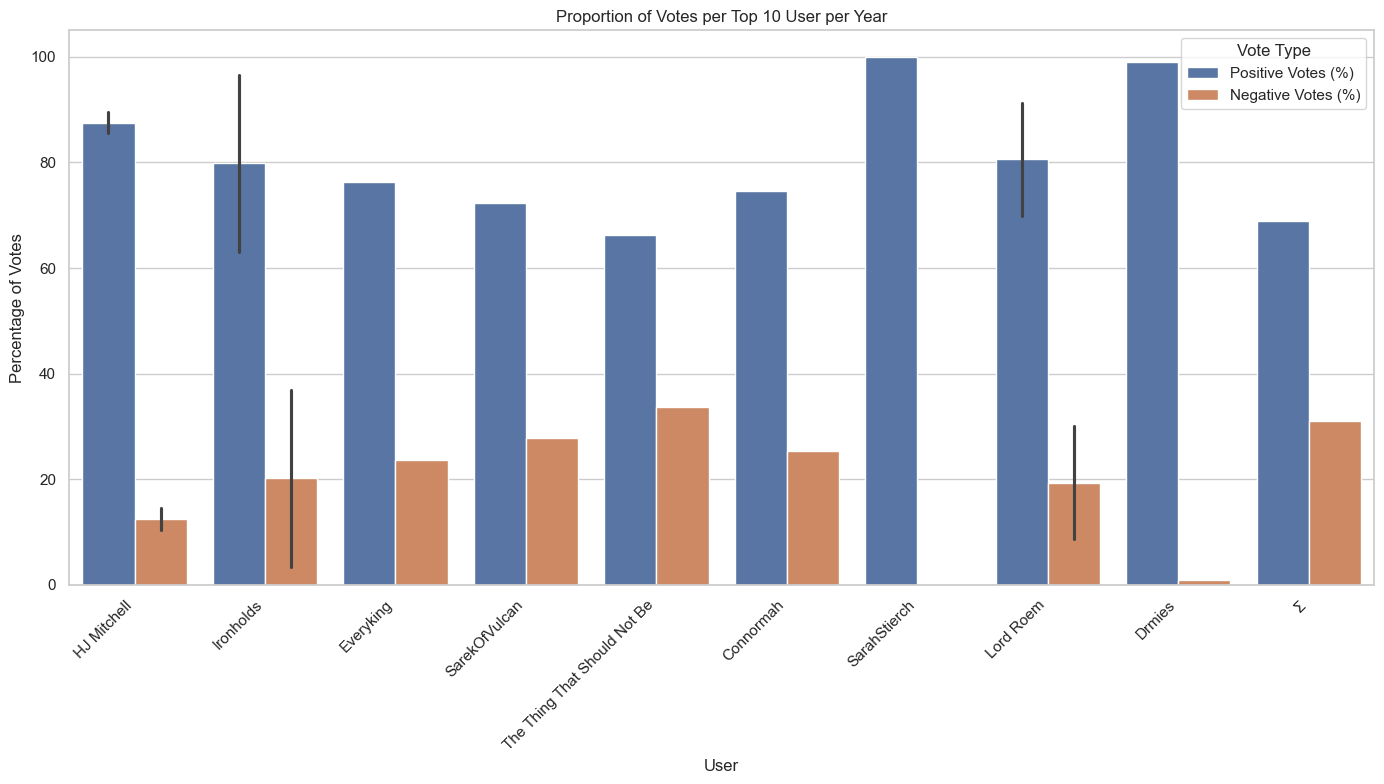

ValueError: Unknown format code 'd' for object of type 'float'

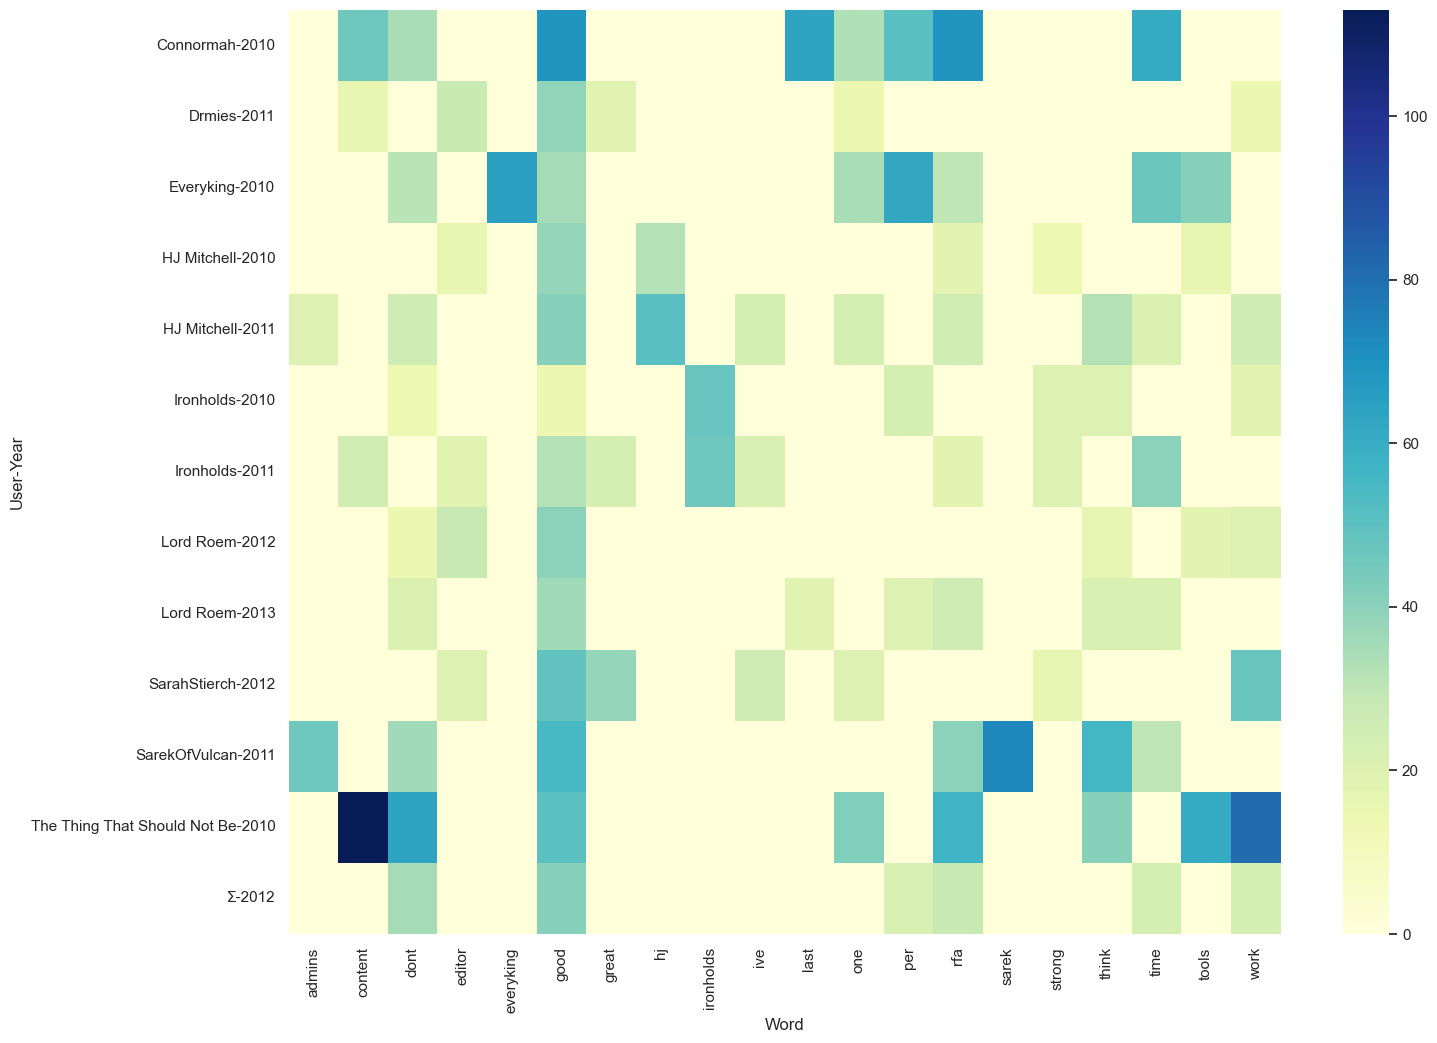

In [11]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
import re
from collections import defaultdict
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk

# Download NLTK data (if not already downloaded)
nltk.download('punkt')
nltk.download('stopwords')

# 1. Data Preparation
# Replace the following line with your actual data loading method
# Example: df = pd.read_csv('your_data.csv')
# For demonstration, we'll assume 'df' is already loaded

# Ensure that the 'DAT' column is in datetime format
df['DAT'] = pd.to_datetime(df['DAT'], errors='coerce')

# Drop rows with invalid dates if any
df = df.dropna(subset=['DAT'])

# Extract the year from the 'DAT' column for easier grouping
df['Year'] = df['DAT'].dt.year

# Optional: Handle missing or malformed 'VOT' values
df = df[df['VOT'].isin([-1, 1])]

# 2. Identify the Top 10 In-Degree Nodes
G = nx.DiGraph()
G.add_edges_from(zip(df['SRC'], df['TGT']))
in_degree_centrality = nx.in_degree_centrality(G)
sorted_in_degree = sorted(in_degree_centrality.items(), key=lambda item: item[1], reverse=True)
top_10_in_degree = sorted_in_degree[:10]
top_10_users = [user for user, centrality in top_10_in_degree]

print("### Top 10 In-Degree Nodes ###\n")
for idx, (user, centrality) in enumerate(top_10_in_degree, start=1):
    print(f"{idx}. {user} - In-Degree Centrality: {centrality:.4f}")

# 3. Proportion of Votes per User per Year
vote_proportion_results = []

for user in top_10_users:
    user_runs = df[df['TGT'] == user]
    vote_counts = user_runs.groupby('Year')['VOT'].value_counts().unstack(fill_value=0)
    vote_proportions = vote_counts.div(vote_counts.sum(axis=1), axis=0) * 100
    for year, row in vote_proportions.iterrows():
        pos_pct = row.get(1, 0)
        neg_pct = row.get(-1, 0)
        vote_proportion_results.append({
            'User': user,
            'Year': year,
            'Positive Votes (%)': round(pos_pct, 2),
            'Negative Votes (%)': round(neg_pct, 2),
            'Total Votes': vote_counts.loc[year].sum()
        })

vote_proportion_df = pd.DataFrame(vote_proportion_results)
print("\n### Proportion of Votes per User per Year ###\n")
print(vote_proportion_df.to_string(index=False))

# 4. Preprocess and Tokenize Comments
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'http\S+|www.\S+', '', text)  # Remove URLs
    text = re.sub(r'[^a-z\s]', '', text)         # Remove non-alphabetic characters
    tokens = word_tokenize(text)
    stop_words = set(stopwords.words('english') + ['support', 'oppose', 'user', 'admin', 
                                                  'candidate', 'wikipedia', 'color',
                                                  'http', 'php', 'org', 'luck', 'font', 
                                                  'see', 'green', 'would', 'e',
                                                  'span', 'style', 'border', '1px', 'index'])
    tokens = [word for word in tokens if word not in stop_words]
    return tokens

df['Cleaned_TXT'] = df['TXT'].apply(preprocess_text)

# 5. Word Frequency Analysis
word_freq_results = defaultdict(lambda: defaultdict(lambda: defaultdict(int)))

for user in top_10_users:
    user_runs = df[df['TGT'] == user]
    for year in user_runs['Year'].unique():
        user_year_runs = user_runs[user_runs['Year'] == year]
        all_tokens = user_year_runs['Cleaned_TXT'].sum()
        word_freq = pd.Series(all_tokens).value_counts()
        top_words = word_freq.head(10)
        word_freq_results[user][year] = top_words.to_dict()

word_freq_list = []

for user, years in word_freq_results.items():
    for year, words in years.items():
        for word, count in words.items():
            word_freq_list.append({
                'User': user,
                'Year': year,
                'Word': word,
                'Count': count
            })

word_freq_df = pd.DataFrame(word_freq_list)
print("\n### Top 10 Most Common Words per User per Year ###\n")
print(word_freq_df.pivot_table(index=['User', 'Year'], columns='Word', values='Count', fill_value=0).to_string())

# 6. TF-IDF Analysis
tfidf_results = defaultdict(lambda: defaultdict(lambda: defaultdict(float)))

for user in top_10_users:
    user_runs = df[df['TGT'] == user]
    for year in user_runs['Year'].unique():
        user_year_runs = user_runs[user_runs['Year'] == year]
        documents = user_year_runs['Cleaned_TXT'].apply(lambda tokens: ' '.join(tokens)).tolist()
        if not documents:
            continue
        tfidf_vectorizer = TfidfVectorizer(max_features=10)
        tfidf_matrix = tfidf_vectorizer.fit_transform(documents)
        feature_names = tfidf_vectorizer.get_feature_names_out()
        tfidf_scores = tfidf_matrix.sum(axis=0).A1
        tfidf_dict = dict(zip(feature_names, tfidf_scores))
        sorted_tfidf = sorted(tfidf_dict.items(), key=lambda item: item[1], reverse=True)
        top_tfidf_words = {word: round(score, 4) for word, score in sorted_tfidf[:10]}
        tfidf_results[user][year] = top_tfidf_words

tfidf_list = []

for user, years in tfidf_results.items():
    for year, words in years.items():
        for word, score in words.items():
            tfidf_list.append({
                'User': user,
                'Year': year,
                'Word': word,
                'TF-IDF Score': score
            })

tfidf_df = pd.DataFrame(tfidf_list)
print("\n### Top 10 TF-IDF Words per User per Year ###\n")
print(tfidf_df.pivot_table(index=['User', 'Year'], columns='Word', values='TF-IDF Score', fill_value=0).to_string())

# 7. Visualization

# 7.1. Vote Proportions Bar Chart
sns.set(style="whitegrid")
plt.figure(figsize=(14, 8))
vote_melted = vote_proportion_df.melt(id_vars=['User', 'Year'], 
                                     value_vars=['Positive Votes (%)', 'Negative Votes (%)'], 
                                     var_name='Vote Type', 
                                     value_name='Percentage')
sns.barplot(x='User', y='Percentage', hue='Vote Type', data=vote_melted)
plt.title('Proportion of Votes per Top 10 User per Year')
plt.xlabel('User')
plt.ylabel('Percentage of Votes')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Vote Type')
plt.tight_layout()
plt.show()

# 7.2. Word Frequency Heatmap
# Select top 10 words across all users and years
top_words_freq = word_freq_df.groupby('Word').sum()['Count'].sort_values(ascending=False).head(20).index.tolist()
filtered_word_freq_df = word_freq_df[word_freq_df['Word'].isin(top_words_freq)]
heatmap_data_freq = filtered_word_freq_df.pivot_table(index=['User', 'Year'], 
                                                      columns='Word', 
                                                      values='Count', 
                                                      fill_value=0)
plt.figure(figsize=(16, 12))
sns.heatmap(heatmap_data_freq, annot=True, fmt="d", cmap='YlGnBu')
plt.title('Top Word Frequencies per User per Year')
plt.xlabel('Words')
plt.ylabel('User and Year')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# 7.3. TF-IDF Heatmap
# Select top 10 TF-IDF words across all users and years
top_words_tfidf = tfidf_df.groupby('Word').sum()['TF-IDF Score'].sort_values(ascending=False).head(20).index.tolist()
filtered_tfidf_df = tfidf_df[tfidf_df['Word'].isin(top_words_tfidf)]
heatmap_data_tfidf = filtered_tfidf_df.pivot_table(index=['User', 'Year'], 
                                                  columns='Word', 
                                                  values='TF-IDF Score', 
                                                  fill_value=0)
plt.figure(figsize=(16, 12))
sns.heatmap(heatmap_data_tfidf, annot=True, fmt=".2f", cmap='OrRd')
plt.title('Top TF-IDF Words per User per Year')
plt.xlabel('Words')
plt.ylabel('User and Year')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# 8. Summary Tables

# 8.1. Vote Proportions Table
vote_proportion_pivot = vote_proportion_df.pivot(index=['User', 'Year'], 
                                                columns='Vote Type', 
                                                values=['Positive Votes (%)', 'Negative Votes (%)']).fillna(0)
print("\n### Vote Proportions per User per Year ###\n")
print(vote_proportion_pivot.to_string())

# 8.2. Word Frequency Table
word_freq_pivot = word_freq_df.pivot_table(index=['User', 'Year'], 
                                          columns='Word', 
                                          values='Count', 
                                          fill_value=0)
print("\n### Top 10 Most Common Words per User per Year ###\n")
print(word_freq_pivot.to_string())

# 8.3. TF-IDF Analysis Table
tfidf_pivot = tfidf_df.pivot_table(index=['User', 'Year'], 
                                   columns='Word', 
                                   values='TF-IDF Score', 
                                   fill_value=0)
print("\n### Top 10 TF-IDF Words per User per Year ###\n")
print(tfidf_pivot.to_string())


In [18]:
hj_mitchell_df = df[df['TGT'] == 'Lord Roem']

hj_mitchell_df

,SRC,TGT,VOT,RES,YEA,DAT,TXT,cleaned_TXT,Year,Cleaned_TXT
866,Status,Lord Roem,1,1,2013,2013-01-20 16:05:00,"'''YESS!!''' <font face=""Arial"" size=""2em"">&nb...",yes nbsp nbsp,2013,"[yess, facearial, sizeemnbspnbsp]"
867,Hahc21,Lord Roem,1,1,2013,2013-01-20 16:22:00,'''''' Is supporting before the candidate's ac...,supporting acceptance allowed,2013,"[supporting, candidates, acceptance, allowed]"
868,NuclearWarfare,Lord Roem,1,1,2013,2013-01-20 20:02:00,"'''<font color=""navy"">",,2013,[colornavy]
869,Ceranthor,Lord Roem,1,1,2013,2013-01-20 20:04:00,"255 edits to his FA, which is well-written. Re...",255 edits fa well written reasonable amount ar...,2013,"[edits, fa, wellwritten, reasonable, amount, a..."
870,Dank,Lord Roem,1,1,2013,2013-01-20 20:05:00,"I supported the last one, so unless there's so...",supported last one unless surprise board dank,2013,"[supported, last, one, unless, theres, surpris..."
...,...,...,...,...,...,...,...,...,...,...
8217,Shadowjams,Lord Roem,-1,-1,2012,2012-06-14 11:21:00,'''''' - I hold iron in the highest of regards...,hold iron highest regard oppose echoing hj poi...,2012,"[hold, iron, highest, regards, echoing, hjs, p..."
8218,Drmies,Lord Roem,-1,-1,2012,2012-06-14 11:36:00,'''''': I saw no reason to weigh in on this Rf...,saw reason weigh extensive knowledge lord roem...,2012,"[saw, reason, weigh, rfa, extensive, knowledge..."
8219,Ncmvocalist,Lord Roem,-1,-1,2012,2012-06-14 15:19:00,Leaky caldron has summed up my view too (but I...,leaky caldron summed view would replace word m...,2012,"[leaky, caldron, summed, view, replace, words,..."
8220,Ktr101,Lord Roem,-1,-1,2012,2012-06-14 15:24:00,"'''''' I'm sorry, but the answers to Questions...",sorry answer question 12 17 bit concerning bet...,2012,"[im, sorry, answers, questions, bit, concernin..."


[nltk_data] Downloading package punkt to /Users/dan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/dan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/dan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Number of users with multiple RfA runs: 33

Top 10 TF-IDF Terms for User '28bytes' in Year 2011:
good         5.401088
great        4.637458
problem      3.996560
time         3.894313
nominator    3.718396
28bytes      3.339291
editor       3.316592
strong       2.998261
concern      2.929179
look         2.865835


Top 10 TF-IDF Terms for User '28bytes' in Year 2010:
experience        3.167857
fine              2.494595
month             2.200478
good              2.112669
edits             2.076647
marmadukepercy    1.952164
enough            1.866844
reluctant         1.788328
area              1.704798
issue             1.613826


Top 10 TF-IDF Terms for User 'Ankitbhatt' in Year 2011:
work          1.527385
experience    1.461029
area          1.274293
anti          0.992401
active        0.961739
vandalism     0.959247
editor        0.938756
good          0.928351
edits         0.869490
interest      0.843830


Top 10 TF-IDF Terms for User 'Ankitbhatt' in Year 2010:
experience  

NameError: name 'plot_top_terms' is not defined

In [22]:
# Import necessary libraries
import re
import pandas as pd
import networkx as nx
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
import warnings

# Download necessary NLTK data (only the first time)
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

# Suppress SettingWithCopyWarning for clarity
warnings.filterwarnings('ignore', category=pd.errors.SettingWithCopyWarning)

# ==========================
# 1. Data Preparation
# ==========================

# Convert 'DAT' to datetime and extract 'Year'
df['DAT'] = pd.to_datetime(df['DAT'], errors='coerce')
df['Year'] = df['DAT'].dt.year

# ==========================
# 2. Create Graph and Calculate In-Degree Centrality
# ==========================

# Create a directed graph from 'SRC' to 'TGT'
G = nx.DiGraph()
G.add_edges_from(df[['SRC', 'TGT']].itertuples(index=False, name=None))

# Calculate in-degree centrality
in_degree_centrality = nx.in_degree_centrality(G)

# ==========================
# 3. Identify Top In-Degree Users
# ==========================

# Define number of top users to select
top_n = 10  # Adjust as needed

# Sort users by in-degree centrality and select top_n
top_in_degree_users = sorted(in_degree_centrality.items(), key=lambda x: x[1], reverse=True)[:top_n]
top_in_degree_users = [user for user, centrality in top_in_degree_users]

print(f"Top {top_n} In-Degree Centrality Users: {top_in_degree_users}\n")

# ==========================
# 4. Identify Users with Multiple RfA Runs
# ==========================

# Group by 'TGT' and count the number of unique years each user has been a target
user_year_counts = df.groupby('TGT')['Year'].nunique()

# Identify users with more than one RfA run (i.e., more than one unique year)
multi_rfa_users = user_year_counts[user_year_counts > 1].index.tolist()

print(f"Number of users with multiple RfA runs: {len(multi_rfa_users)}\n")

# ==========================
# 5. Identify Users Who Are Both Top In-Degree and Have Multiple RfA Runs
# ==========================

# Find intersection of top_in_degree_users and multi_rfa_users
selected_users = list(set(top_in_degree_users).intersection(set(multi_rfa_users)))

print(f"Users who are both top in-degree and have multiple RfA runs: {selected_users}\n")

# Check if there are any users meeting both criteria
if not selected_users:
    print("No users meet both criteria. Consider increasing 'top_n' or verifying your data.")
else:
    # ==========================
    # 6. Preprocessing and Tokenization
    # ==========================

    # Instantiate Lemmatizer and Stemmer
    lmtzr = WordNetLemmatizer()
    porter = PorterStemmer()
    
    # Define stopwords
    additional_stopwords = [
        'support', 'oppose', 'user', 'admin', 'candidate', 'wikipedia', 'color',
        'http', 'php', 'org', 'luck', 'font', 'see', 'green', 'would', 'e',
        'span', 'style', 'border', '1px', 'index'
    ]
    stop_words = set(stopwords.words('english') + additional_stopwords)
    
    # Function to process tokens
    def abbr_or_lower(word):
        """
        Keeps abbreviations (e.g., "HJ") as-is or converts to lowercase.
        """
        if re.match(r'([A-Z]+[a-z]*){2,}', word):
            return word
        else:
            return word.lower()
    
    def tokenize(words, modulation):
        """
        Tokenizes and processes text.
        
        Parameters:
        - words (str): The text to tokenize.
        - modulation (int): Determines the processing method.
            - 0: No modification.
            - 1: Stemming.
            - 2: Lemmatization.
        
        Returns:
        - List[str]: A list of processed tokens.
        """
        tokens = re.split(r'\W+', words)
        stems = []
        # Filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
        for token in tokens:
            lowers = abbr_or_lower(token)
            if lowers not in stop_words:
                if re.search('[a-zA-Z]', lowers):
                    if modulation == 1:
                        stems.append(porter.stem(lowers))
                    elif modulation == 2:
                        stems.append(lmtzr.lemmatize(lowers))
                    else:
                        stems.append(lowers)
        return stems
    
    # ==========================
    # 7. Filter DataFrame for Selected Users
    # ==========================

    # Since RfA runs are about being targets ('TGT'), we should filter based on 'TGT'
    df_selected = df[df['TGT'].isin(selected_users)].copy()

    # Ensure that the 'cleaned_TXT' column is in string format and handle NaN values by replacing them with an empty string
    df_selected['cleaned_TXT'] = df_selected['cleaned_TXT'].fillna('').astype(str)
    
    # ==========================
    # 8. TF-IDF Analysis for Selected Users Per Year
    # ==========================

    # Create a dictionary to store TF-IDF results for each user
    user_tfidf_results = {}
    
    for user in selected_users:
        # Initialize nested dictionary for each user
        user_tfidf_results[user] = {}
        
        # Get the years the user has been a target
        user_years = df_selected[df_selected['TGT'] == user]['Year'].unique()
        
        for year in user_years:
            # Filter comments where the user is the target and the year matches
            user_year_data = df_selected[(df_selected['TGT'] == user) & (df_selected['Year'] == year)].copy()
            
            # Extract and preprocess comments
            comments = user_year_data['cleaned_TXT'].fillna('').astype(str)
            comments_tokenized = [tokenize(comment, modulation=2) for comment in comments]  # Using lemmatization
            
            # Remove empty token lists
            comments_tokenized = [tokens for tokens in comments_tokenized if len(tokens) > 0]
            
            if not comments_tokenized:
                print(f"No comments to analyze for user '{user}' in year {year}.\n")
                continue
            
            # Instantiate TF-IDF Vectorizer for Unigrams, Bigrams, and Trigrams
            tfidf_unigram = TfidfVectorizer(ngram_range=(1, 1), tokenizer=lambda doc: doc, lowercase=False)
            tfidf_bigram = TfidfVectorizer(ngram_range=(2, 2), tokenizer=lambda doc: doc, lowercase=False)
            tfidf_trigram = TfidfVectorizer(ngram_range=(3, 3), tokenizer=lambda doc: doc, lowercase=False)
            
            # Compute TF-IDF for Unigrams
            tfidf_matrix_unigram = tfidf_unigram.fit_transform(comments_tokenized)
            tfidf_df_unigram = pd.DataFrame.sparse.from_spmatrix(tfidf_matrix_unigram, columns=tfidf_unigram.get_feature_names_out())
            tfidf_df_unigram = tfidf_df_unigram.sum(axis=0).sort_values(ascending=False)
            
            # Compute TF-IDF for Bigrams
            tfidf_matrix_bigram = tfidf_bigram.fit_transform(comments_tokenized)
            tfidf_df_bigram = pd.DataFrame.sparse.from_spmatrix(tfidf_matrix_bigram, columns=tfidf_bigram.get_feature_names_out())
            tfidf_df_bigram = tfidf_df_bigram.sum(axis=0).sort_values(ascending=False)
            
            # Compute TF-IDF for Trigrams
            tfidf_matrix_trigram = tfidf_trigram.fit_transform(comments_tokenized)
            tfidf_df_trigram = pd.DataFrame.sparse.from_spmatrix(tfidf_matrix_trigram, columns=tfidf_trigram.get_feature_names_out())
            tfidf_df_trigram = tfidf_df_trigram.sum(axis=0).sort_values(ascending=False)
            
            # Store the results in the dictionary
            user_tfidf_results[user][year] = {
                'Unigrams': tfidf_df_unigram.head(10),
                'Bigrams': tfidf_df_bigram.head(10),
                'Trigrams': tfidf_df_trigram.head(10)
            }
            
            # Print the top terms for this user and year
            print(f"\nTop Unigrams for User '{user}' in Year {year}:")
            print(user_tfidf_results[user][year]['Unigrams'])
            
            print(f"\nTop Bigrams for User '{user}' in Year {year}:")
            print(user_tfidf_results[user][year]['Bigrams'])
            
            print(f"\nTop Trigrams for User '{user}' in Year {year}:")
            print(user_tfidf_results[user][year]['Trigrams'])
    
    # ==========================
    # 9. Admin Status of Selected Users
    # ==========================

    # Create a dictionary to store admin status for each selected user
    user_admin_status = {}
    
    # Loop through each selected user to check if they are admins
    for user in selected_users:
        if user in G.nodes:
            status = G.nodes[user].get('admin', 'Unknown')
        else:
            status = 'Unknown'
        user_admin_status[user] = status
    
    # Print out the admin status for each user
    print("\nAdmin Status of Selected Users:")
    for user, status in user_admin_status.items():
        print(f"User '{user}' is {status}.")
    
    # ==========================
    # 10. Proportion of Support Votes for Selected Users
    # ==========================

    # Create a dictionary to store support vote proportions for each selected user
    user_support_proportion = {}
    
    for user in selected_users:
        # Get the user's votes from the dataframe where they are the target
        # Assuming 'VOT' indicates the type of vote towards the user
        # Here, 'VOT' = 1 means support, '-1' means oppose
        user_votes = df_selected[df_selected['TGT'] == user]
        
        # Calculate the total number of votes (support + oppose)
        total_votes = user_votes.shape[0]
        
        # Calculate the number of support votes
        support_votes = user_votes[user_votes['VOT'] == 1].shape[0]
        
        # Calculate the proportion of support votes
        if total_votes > 0:
            support_proportion = support_votes / total_votes
        else:
            support_proportion = 0  # If no votes, proportion is 0
        
        # Store the result for this user
        user_support_proportion[user] = support_proportion
    
    # Print out the support proportion for each user
    print("\nProportion of Support Votes for Selected Users:")
    for user, proportion in user_support_proportion.items():
        print(f"User '{user}' has a support vote proportion of {proportion:.2f}.")


[nltk_data] Downloading package punkt to /Users/dan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/dan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/dan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
/opt/anaconda3/envs/ADC/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/anaconda3/envs/ADC/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Top 10 In-Degree Centrality Users: ['HJ Mitchell', 'Ironholds', 'Everyking', 'SarekOfVulcan', 'The Thing That Should Not Be', 'Connormah', 'SarahStierch', 'Lord Roem', 'Drmies', 'Σ']

Number of users with multiple RfA runs: 33

Users who are both top in-degree and have multiple RfA runs: ['Lord Roem', 'Ironholds', 'HJ Mitchell']



/opt/anaconda3/envs/ADC/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/anaconda3/envs/ADC/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/anaconda3/envs/ADC/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(



Top Unigrams for User 'Lord Roem' in Year 2013:
concern         6.808278
good            6.183593
reason          5.630927
time            5.137632
editor          4.124372
last            4.033334
contribution     3.72245
well             3.38928
arbcom          3.368946
think           3.216634
dtype: Sparse[float64, 0]

Top Bigrams for User 'Lord Roem' in Year 2013:
last time             3.129601
lord roem             2.067986
first time            1.626148
arbcom clerk          1.615493
good contribution     1.597681
abuse tool            1.447157
look good             1.375316
seems trustworthy     1.224424
solid contribution    1.148166
experience medcom     1.059451
dtype: Sparse[float64, 0]

Top Trigrams for User 'Lord Roem' in Year 2013:
think abuse tool                   1.09692
clueful unlikely break                 1.0
assessment roem contribution           1.0
supporting acceptance allowed          1.0
solid contribution encyclopedia        1.0
impressed experience medcom

/opt/anaconda3/envs/ADC/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(



Top Unigrams for User 'Lord Roem' in Year 2012:
good            6.594353
seems           3.912651
experience      3.542975
editor          3.342437
work            3.327733
concern         3.193285
tool            3.023804
contribution    2.697257
enough           2.58609
nothing         2.373931
dtype: Sparse[float64, 0]

Top Bigrams for User 'Lord Roem' in Year 2012:
lord roem            1.441577
edit count           1.435737
good work            1.038701
seems like           1.031339
darn sven                 1.0
reason stated             1.0
good contribution         1.0
seems ready               1.0
fine good            0.968761
seems good            0.86371
dtype: Sparse[float64, 0]

Top Trigrams for User 'Lord Roem' in Year 2012:
malleus need experience         1.0
sorry enough experience         1.0
dr work impressive              1.0
imperfect seems clue            1.0
thought already honest          1.0
believe abuse tool              1.0
seen nothing positive           1.0


/opt/anaconda3/envs/ADC/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/anaconda3/envs/ADC/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/anaconda3/envs/ADC/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/anaconda3/envs/ADC/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(



Top Unigrams for User 'Ironholds' in Year 2011:
time           7.403549
good           5.696649
strong          5.41692
great          5.244488
concern        5.070252
ironholds      4.432241
editor         3.917101
last           3.178676
already        3.024688
contributor    3.005269
dtype: Sparse[float64, 0]

Top Bigrams for User 'Ironholds' in Year 2011:
thought already        3.070066
last time              2.391743
previous rfas          1.410662
long time              1.384671
answer question        1.223271
good thing             1.099991
concern nbsp                1.0
strong concern              1.0
strong glad                 1.0
clearly appropriate         1.0
dtype: Sparse[float64, 0]

Top Trigrams for User 'Ironholds' in Year 2011:
seen editor around            1.00864
excellent contributor well        1.0
great trusted mop                 1.0
waiting long time                 1.0
last time happy                   1.0
need lawyer making                1.0
even offered c

/opt/anaconda3/envs/ADC/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/anaconda3/envs/ADC/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(



Top Unigrams for User 'Ironholds' in Year 2010:
ironholds    4.342965
strong       4.025769
concern      3.600099
good         3.496188
positive     3.425364
net          3.017854
time         2.660968
think        2.584466
fine          2.36903
editor       2.350015
dtype: Sparse[float64, 0]

Top Bigrams for User 'Ironholds' in Year 2010:
net positive          3.045871
strong nominator      1.316688
concern judgment      1.263172
look fine                  1.0
nw nomination              1.0
ja good                    1.0
concern whatsoever         1.0
absolutely fine            1.0
hard working               1.0
sloppy csd            0.904112
dtype: Sparse[float64, 0]

Top Trigrams for User 'Ironholds' in Year 2010:
happy new year                      1.0
thought already one                 1.0
interaction mostly positive         1.0
strong trust absolutely             1.0
ceranthor triplestop others         1.0
weak net positive                   1.0
mostly amory currently          

/opt/anaconda3/envs/ADC/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/anaconda3/envs/ADC/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/anaconda3/envs/ADC/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/anaconda3/envs/ADC/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(



Top Unigrams for User 'HJ Mitchell' in Year 2011:
hj           7.258238
good         6.837353
one          4.972183
strong       4.804398
work         4.691774
think        4.374588
great        4.304574
obviously    4.251532
admins       3.775525
like         3.707697
dtype: Sparse[float64, 0]

Top Bigrams for User 'HJ Mitchell' in Year 2011:
hj mitchell       2.756424
one best          1.770256
strong great       1.70677
best admins       1.556641
make mistake      1.422108
net positive      1.315742
excellent work    1.309103
trust hj          1.277684
good work         1.110535
excellent job     1.043107
dtype: Sparse[float64, 0]

Top Trigrams for User 'HJ Mitchell' in Year 2011:
one best admins          1.6047
excellent work itn          1.0
please return uaa           1.0
done excellent job          1.0
great nice guy              1.0
one valuable admins         1.0
everyone make mistake       1.0
trust hj wikilife           1.0
ok already win              1.0
fine work hj      

/opt/anaconda3/envs/ADC/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/anaconda3/envs/ADC/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(



Top Unigrams for User 'HJ Mitchell' in Year 2010:
good        7.542892
hj          4.558492
look        4.202357
strong      4.146816
reason      3.741888
editor      3.694174
trust       3.664365
tool        3.488627
mitchell    3.042325
great       2.986734
dtype: Sparse[float64, 0]

Top Bigrams for User 'HJ Mitchell' in Year 2010:
hj mitchell           2.814971
net positive          2.713985
look good             2.679475
trust tool            1.228705
good thing            1.069293
trust editor          1.030153
take slow                  1.0
good involvement           1.0
strong excellent           1.0
trustworthy editor         1.0
dtype: Sparse[float64, 0]

Top Trigrams for User 'HJ Mitchell' in Year 2010:
strong recommend closing                1.0
sure qualified trusted                  1.0
mistake like tolerated                  1.0
qualified without lost                  1.0
good head shoulder                      1.0
look good reason                        1.0
problem look

In [23]:
# Import necessary libraries
import re
import pandas as pd
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer, PorterStemmer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
import networkx as nx
import matplotlib.pyplot as plt
import warnings

# Download necessary NLTK data (only the first time)
import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

# Suppress SettingWithCopyWarning for clarity
warnings.filterwarnings('ignore', category=pd.errors.SettingWithCopyWarning)


# Calculate in-degree centrality
in_degree_centrality = nx.in_degree_centrality(G)

# ==========================
# 3. Identify Top In-Degree Users
# ==========================

# Define number of top users to select
top_n = 10  # Adjust as needed

# Sort users by in-degree centrality and select top_n
top_in_degree_users = sorted(in_degree_centrality.items(), key=lambda x: x[1], reverse=True)[:top_n]
top_in_degree_users = [user for user, centrality in top_in_degree_users]

print(f"Top {top_n} In-Degree Centrality Users: {top_in_degree_users}\n")

# ==========================
# 4. Identify Users with Multiple RfA Runs
# ==========================

# Group by 'TGT' and count the number of unique years each user has been a target
user_year_counts = df.groupby('TGT')['Year'].nunique()

# Identify users with more than one RfA run (i.e., more than one unique year)
multi_rfa_users = user_year_counts[user_year_counts > 1].index.tolist()

print(f"Number of users with multiple RfA runs: {len(multi_rfa_users)}\n")

# ==========================
# 5. Identify Users Who Are Both Top In-Degree and Have Multiple RfA Runs
# ==========================

# Find intersection of top_in_degree_users and multi_rfa_users
selected_users = list(set(top_in_degree_users).intersection(set(multi_rfa_users)))

print(f"Users who are both top in-degree and have multiple RfA runs: {selected_users}\n")

# Check if there are any users meeting both criteria
if not selected_users:
    print("No users meet both criteria. Consider increasing 'top_n' or verifying your data.")
else:
    # ==========================
    # 6. Preprocessing and Tokenization
    # ==========================
    
    # Instantiate Lemmatizer and Stemmer
    lmtzr = WordNetLemmatizer()
    porter = PorterStemmer()
    
    # Define stopwords
    additional_stopwords = [
        'support', 'oppose', 'user', 'admin', 'candidate', 'wikipedia', 'color',
        'http', 'php', 'org', 'luck', 'font', 'see', 'green', 'would', 'e',
        'span', 'style', 'border', '1px', 'index'
    ]
    stop_words = set(stopwords.words('english') + additional_stopwords)
    
    # Function to get text in desired lowercase form
    def abbr_or_lower(word):
        if re.match(r'([A-Z]+[a-z]*){2,}', word):
            return word
        else:
            return word.lower()
    
    # Function for tokenization with stemming or lemmatization
    def tokenize(words, modulation):
        tokens = re.split(r'\W+', words)
        stems = []
        # Filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
        for token in tokens:
            lowers = abbr_or_lower(token)
            if lowers not in stop_words:
                if re.search('[a-zA-Z]', lowers):
                    if modulation == 1:
                        stems.append(porter.stem(lowers))
                    elif modulation == 2:
                        stems.append(lmtzr.lemmatize(lowers))
                    else:
                        stems.append(lowers)
        return stems
    
    # ==========================
    # 7. Filter DataFrame for Selected Users
    # ==========================
    
    # Since RfA runs are about being targets ('TGT'), we should filter based on 'TGT'
    df_selected = df[df['TGT'].isin(selected_users)].copy()
    
    # Ensure that the 'cleaned_TXT' column is in string format and handle NaN values by replacing them with an empty string
    df_selected['cleaned_TXT'] = df_selected['cleaned_TXT'].fillna('').astype(str)
    
    # ==========================
    # 8. TF-IDF Analysis for Selected Users Per Year
    # ==========================
    
    # Create a dictionary to store TF-IDF results for each user
    user_tfidf_results = {}
    
    for user in selected_users:
        # Initialize nested dictionary for each user
        user_tfidf_results[user] = {}
        
        # Get the years the user has been a target
        user_years = df_selected[df_selected['TGT'] == user]['Year'].unique()
        
        for year in user_years:
            # Filter comments where the user is the target and the year matches
            user_year_data = df_selected[(df_selected['TGT'] == user) & (df_selected['Year'] == year)].copy()
            
            # Extract and preprocess comments
            comments = user_year_data['cleaned_TXT'].fillna('').astype(str)
            comments_tokenized = [tokenize(comment, modulation=2) for comment in comments]  # Using lemmatization
            
            # Remove empty token lists
            comments_tokenized = [tokens for tokens in comments_tokenized if len(tokens) > 0]
            
            if not comments_tokenized:
                print(f"No comments to analyze for user '{user}' in year {year}.\n")
                continue
            
            # Instantiate TF-IDF Vectorizer for Unigrams, Bigrams, and Trigrams
            tfidf_unigram = TfidfVectorizer(ngram_range=(1, 1), tokenizer=lambda doc: doc, lowercase=False)
            tfidf_bigram = TfidfVectorizer(ngram_range=(2, 2), tokenizer=lambda doc: doc, lowercase=False)
            tfidf_trigram = TfidfVectorizer(ngram_range=(3, 3), tokenizer=lambda doc: doc, lowercase=False)
            
            # Compute TF-IDF for Unigrams
            tfidf_matrix_unigram = tfidf_unigram.fit_transform(comments_tokenized)
            tfidf_df_unigram = pd.DataFrame.sparse.from_spmatrix(tfidf_matrix_unigram, columns=tfidf_unigram.get_feature_names_out())
            tfidf_df_unigram = tfidf_df_unigram.sum(axis=0).sort_values(ascending=False)
            
            # Compute TF-IDF for Bigrams
            tfidf_matrix_bigram = tfidf_bigram.fit_transform(comments_tokenized)
            tfidf_df_bigram = pd.DataFrame.sparse.from_spmatrix(tfidf_matrix_bigram, columns=tfidf_bigram.get_feature_names_out())
            tfidf_df_bigram = tfidf_df_bigram.sum(axis=0).sort_values(ascending=False)
            
            # Compute TF-IDF for Trigrams
            tfidf_matrix_trigram = tfidf_trigram.fit_transform(comments_tokenized)
            tfidf_df_trigram = pd.DataFrame.sparse.from_spmatrix(tfidf_matrix_trigram, columns=tfidf_trigram.get_feature_names_out())
            tfidf_df_trigram = tfidf_df_trigram.sum(axis=0).sort_values(ascending=False)
            
            # Store the results in the dictionary
            user_tfidf_results[user][year] = {
                'Unigrams': tfidf_df_unigram.head(10),
                'Bigrams': tfidf_df_bigram.head(10),
                'Trigrams': tfidf_df_trigram.head(10)
            }
            
            # Print the top terms for this user and year
            print(f"\nTop Unigrams for User '{user}' in Year {year}:")
            print(user_tfidf_results[user][year]['Unigrams'])
            
            print(f"\nTop Bigrams for User '{user}' in Year {year}:")
            print(user_tfidf_results[user][year]['Bigrams'])
            
            print(f"\nTop Trigrams for User '{user}' in Year {year}:")
            print(user_tfidf_results[user][year]['Trigrams'])
    
    # ==========================
    # 9. Admin Status of Selected Users
    # ==========================
    
    # Create a dictionary to store admin status for each selected user
    user_admin_status = {}
    
    # Loop through each selected user to check if they are admins
    for user in selected_users:
        if user in G.nodes:
            status = G.nodes[user].get('admin', 'Unknown')
        else:
            status = 'Unknown'
        user_admin_status[user] = status
    
    # Print out the admin status for each user
    print("\nAdmin Status of Selected Users:")
    for user, status in user_admin_status.items():
        print(f"User '{user}' is {status}.")
    
    # ==========================
    # 10. Proportion of Support Votes for Selected Users
    # ==========================
    
    # Create a dictionary to store support vote proportions for each selected user
    user_support_proportion = {}
    
    for user in selected_users:
        # Get the user's votes from the dataframe where they are the target
        # Assuming 'VOT' indicates the type of vote towards the user
        # Here, 'VOT' = 1 means support, '-1' means oppose
        user_votes = df_selected[df_selected['TGT'] == user]
        
        # Calculate the total number of votes (support + oppose)
        total_votes = user_votes.shape[0]
        
        # Calculate the number of support votes
        support_votes = user_votes[user_votes['VOT'] == 1].shape[0]
        
        # Calculate the proportion of support votes
        if total_votes > 0:
            support_proportion = support_votes / total_votes
        else:
            support_proportion = 0  # If no votes, proportion is 0
        
        # Store the result for this user
        user_support_proportion[user] = support_proportion
    
    # Print out the support proportion for each user
    print("\nProportion of Support Votes for Selected Users:")
    for user, proportion in user_support_proportion.items():
        print(f"User '{user}' has a support vote proportion of {proportion:.2f}.")
    
    # ==========================
    # 11. Identify Users with 100% Approval or Disapproval
    # ==========================
    
    # Group by 'TGT' and collect unique 'VOT' values
    vote_groups = df.groupby('TGT')['VOT'].unique()
    
    # Identify users with all votes as support (1) or all as oppose (-1)
    users_100_support = vote_groups[vote_groups.apply(lambda x: set(x) == {1})].index.tolist()
    users_100_oppose = vote_groups[vote_groups.apply(lambda x: set(x) == {-1})].index.tolist()
    
    # Print users with 100% support votes
    if users_100_support:
        print("\nUsers with 100% Support Votes:")
        for user in users_100_support:
            print(f"- {user}")
    else:
        print("\nNo users achieved 100% Support Votes.")
    
    # Print users with 100% oppose votes
    if users_100_oppose:
        print("\nUsers with 100% Oppose Votes:")
        for user in users_100_oppose:
            print(f"- {user}")
    else:
        print("\nNo users achieved 100% Oppose Votes.")


[nltk_data] Downloading package punkt to /Users/dan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/dan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/dan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
/opt/anaconda3/envs/ADC/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/anaconda3/envs/ADC/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Top 10 In-Degree Centrality Users: ['HJ Mitchell', 'Ironholds', 'Everyking', 'SarekOfVulcan', 'The Thing That Should Not Be', 'Connormah', 'SarahStierch', 'Lord Roem', 'Drmies', 'Σ']

Number of users with multiple RfA runs: 33

Users who are both top in-degree and have multiple RfA runs: ['Lord Roem', 'Ironholds', 'HJ Mitchell']



/opt/anaconda3/envs/ADC/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/anaconda3/envs/ADC/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(



Top Unigrams for User 'Lord Roem' in Year 2013:
concern         6.808278
good            6.183593
reason          5.630927
time            5.137632
editor          4.124372
last            4.033334
contribution     3.72245
well             3.38928
arbcom          3.368946
think           3.216634
dtype: Sparse[float64, 0]

Top Bigrams for User 'Lord Roem' in Year 2013:
last time             3.129601
lord roem             2.067986
first time            1.626148
arbcom clerk          1.615493
good contribution     1.597681
abuse tool            1.447157
look good             1.375316
seems trustworthy     1.224424
solid contribution    1.148166
experience medcom     1.059451
dtype: Sparse[float64, 0]

Top Trigrams for User 'Lord Roem' in Year 2013:
think abuse tool                   1.09692
clueful unlikely break                 1.0
assessment roem contribution           1.0
supporting acceptance allowed          1.0
solid contribution encyclopedia        1.0
impressed experience medcom

/opt/anaconda3/envs/ADC/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/anaconda3/envs/ADC/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(



Top Unigrams for User 'Lord Roem' in Year 2012:
good            6.594353
seems           3.912651
experience      3.542975
editor          3.342437
work            3.327733
concern         3.193285
tool            3.023804
contribution    2.697257
enough           2.58609
nothing         2.373931
dtype: Sparse[float64, 0]

Top Bigrams for User 'Lord Roem' in Year 2012:
lord roem            1.441577
edit count           1.435737
good work            1.038701
seems like           1.031339
darn sven                 1.0
reason stated             1.0
good contribution         1.0
seems ready               1.0
fine good            0.968761
seems good            0.86371
dtype: Sparse[float64, 0]

Top Trigrams for User 'Lord Roem' in Year 2012:
malleus need experience         1.0
sorry enough experience         1.0
dr work impressive              1.0
imperfect seems clue            1.0
thought already honest          1.0
believe abuse tool              1.0
seen nothing positive           1.0


/opt/anaconda3/envs/ADC/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/anaconda3/envs/ADC/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/anaconda3/envs/ADC/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/anaconda3/envs/ADC/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(



Top Unigrams for User 'Ironholds' in Year 2011:
time           7.403549
good           5.696649
strong          5.41692
great          5.244488
concern        5.070252
ironholds      4.432241
editor         3.917101
last           3.178676
already        3.024688
contributor    3.005269
dtype: Sparse[float64, 0]

Top Bigrams for User 'Ironholds' in Year 2011:
thought already        3.070066
last time              2.391743
previous rfas          1.410662
long time              1.384671
answer question        1.223271
good thing             1.099991
concern nbsp                1.0
strong concern              1.0
strong glad                 1.0
clearly appropriate         1.0
dtype: Sparse[float64, 0]

Top Trigrams for User 'Ironholds' in Year 2011:
seen editor around            1.00864
excellent contributor well        1.0
great trusted mop                 1.0
waiting long time                 1.0
last time happy                   1.0
need lawyer making                1.0
even offered c

/opt/anaconda3/envs/ADC/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/anaconda3/envs/ADC/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(



Top Unigrams for User 'Ironholds' in Year 2010:
ironholds    4.342965
strong       4.025769
concern      3.600099
good         3.496188
positive     3.425364
net          3.017854
time         2.660968
think        2.584466
fine          2.36903
editor       2.350015
dtype: Sparse[float64, 0]

Top Bigrams for User 'Ironholds' in Year 2010:
net positive          3.045871
strong nominator      1.316688
concern judgment      1.263172
look fine                  1.0
nw nomination              1.0
ja good                    1.0
concern whatsoever         1.0
absolutely fine            1.0
hard working               1.0
sloppy csd            0.904112
dtype: Sparse[float64, 0]

Top Trigrams for User 'Ironholds' in Year 2010:
happy new year                      1.0
thought already one                 1.0
interaction mostly positive         1.0
strong trust absolutely             1.0
ceranthor triplestop others         1.0
weak net positive                   1.0
mostly amory currently          

/opt/anaconda3/envs/ADC/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/anaconda3/envs/ADC/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/anaconda3/envs/ADC/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/anaconda3/envs/ADC/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(



Top Unigrams for User 'HJ Mitchell' in Year 2011:
hj           7.258238
good         6.837353
one          4.972183
strong       4.804398
work         4.691774
think        4.374588
great        4.304574
obviously    4.251532
admins       3.775525
like         3.707697
dtype: Sparse[float64, 0]

Top Bigrams for User 'HJ Mitchell' in Year 2011:
hj mitchell       2.756424
one best          1.770256
strong great       1.70677
best admins       1.556641
make mistake      1.422108
net positive      1.315742
excellent work    1.309103
trust hj          1.277684
good work         1.110535
excellent job     1.043107
dtype: Sparse[float64, 0]

Top Trigrams for User 'HJ Mitchell' in Year 2011:
one best admins          1.6047
excellent work itn          1.0
please return uaa           1.0
done excellent job          1.0
great nice guy              1.0
one valuable admins         1.0
everyone make mistake       1.0
trust hj wikilife           1.0
ok already win              1.0
fine work hj      

/opt/anaconda3/envs/ADC/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/anaconda3/envs/ADC/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(



Top Unigrams for User 'HJ Mitchell' in Year 2010:
good        7.542892
hj          4.558492
look        4.202357
strong      4.146816
reason      3.741888
editor      3.694174
trust       3.664365
tool        3.488627
mitchell    3.042325
great       2.986734
dtype: Sparse[float64, 0]

Top Bigrams for User 'HJ Mitchell' in Year 2010:
hj mitchell           2.814971
net positive          2.713985
look good             2.679475
trust tool            1.228705
good thing            1.069293
trust editor          1.030153
take slow                  1.0
good involvement           1.0
strong excellent           1.0
trustworthy editor         1.0
dtype: Sparse[float64, 0]

Top Trigrams for User 'HJ Mitchell' in Year 2010:
strong recommend closing                1.0
sure qualified trusted                  1.0
mistake like tolerated                  1.0
qualified without lost                  1.0
good head shoulder                      1.0
look good reason                        1.0
problem look